In [132]:
import numpy as np
import pandas as pd

import pickle as pkl

import gc
from sklearn.model_selection import KFold
from cuml.metrics import mean_absolute_error, mean_squared_error

import seaborn as sns

In [133]:
out_base_path = '/media/hiroki/working/kaggle/trends-neuroimaging/models'

In [134]:
OUTPUT_DICT = ''

ID = 'Id'
TARGET_COLS = ['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']
SEED = 2020

N_FOLD = 15

In [135]:
base_path = '/media/hiroki/share/kaggle_data/trends-assessment-prediction/'
train = pd.read_csv(base_path+'train_scores.csv', dtype={'Id':str})\
            #.dropna().reset_index(drop=True) # to make things easy
reveal_ID = pd.read_csv(base_path+'reveal_ID_site2.csv', dtype={'Id':str})
ICN_numbers = pd.read_csv(base_path+'ICN_numbers.csv')
loading = pd.read_csv(base_path+'loading.csv', dtype={'Id':str})
fnc = pd.read_csv(base_path+'fnc.csv', dtype={'Id':str})
sample_submission = pd.read_csv(base_path+'sample_submission.csv', dtype={'Id':str})

In [136]:
fnc_features, loading_features = list(fnc.columns[1:]), list(loading.columns[1:])

In [137]:
sample_submission['ID_num'] = sample_submission[ID].apply(lambda x: int(x.split('_')[0]))
test = pd.DataFrame({ID: sample_submission['ID_num'].unique().astype(str)})
del sample_submission['ID_num']; gc.collect()
test.head()

,Id
0,10003
1,10006
2,10010
3,10011
4,10012


In [138]:
test.head()

,Id
0,10003
1,10006
2,10010
3,10011
4,10012


In [139]:
# merge
train = train.merge(loading, on=ID, how='left')
train = train.merge(fnc, on=ID, how='left')
train

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2,IC_01,IC_07,IC_05,IC_16,...,CBN(13)_vs_DMN(94),CBN(18)_vs_DMN(94),CBN(4)_vs_DMN(94),CBN(7)_vs_DMN(94),CBN(18)_vs_CBN(13),CBN(4)_vs_CBN(13),CBN(7)_vs_CBN(13),CBN(4)_vs_CBN(18),CBN(7)_vs_CBN(18),CBN(7)_vs_CBN(4)
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998,0.006070,0.014466,0.004136,0.000658,...,-0.149279,0.552841,0.131046,0.335446,0.394867,-0.042853,0.124627,-0.060712,0.515964,0.290488
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361,0.009087,0.009291,0.007049,-0.002076,...,-0.214216,-0.039792,0.143014,-0.189962,0.498373,0.444231,0.592438,0.028649,0.705524,0.248327
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641,0.004675,0.000957,0.006154,-0.000429,...,-0.130339,0.309540,0.141469,0.030853,0.344394,0.214097,0.317556,0.012435,0.665937,0.081358
3,10005,66.532630,NaN,NaN,52.108977,69.993075,-0.000398,0.006878,0.009051,0.000369,...,-0.139525,0.394932,0.040443,0.428334,0.498837,0.266755,0.227379,0.028984,0.752343,0.087898
4,10007,38.617381,49.197021,65.674285,40.151376,34.096421,0.005192,0.010585,0.012160,-0.000920,...,-0.150218,0.408926,0.072004,0.157582,0.532046,0.355448,0.462675,0.161005,0.703679,0.293607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5872,21746,14.257265,21.358872,61.165998,51.778483,54.640179,-0.001115,0.007108,0.008652,0.003596,...,-0.249481,0.205351,0.012067,0.310750,0.426335,0.193812,0.158720,0.055471,0.568766,0.160516
5873,21747,55.456978,68.169675,29.907995,55.349257,54.019517,0.007263,0.016489,0.012704,0.004357,...,-0.119170,0.201846,-0.008290,0.119828,0.551936,0.598931,0.511816,0.303312,0.704483,0.461588
5874,21750,48.948756,55.114811,60.878271,38.617246,50.679885,0.005996,0.003873,0.012353,0.000242,...,-0.103786,0.375065,0.104857,0.262614,0.502715,0.322353,0.458041,0.343754,0.705207,0.341224
5875,21752,66.532630,59.844808,72.303110,55.458281,46.870235,0.000627,0.011407,0.010957,0.000534,...,0.229712,0.431489,0.039062,0.119474,0.523894,0.445209,0.332011,0.228977,0.560968,0.263504


In [140]:
# merge
test = test.merge(loading, on=ID, how='left')
test = test.merge(fnc, on=ID, how='left')
test

,Id,IC_01,IC_07,IC_05,IC_16,IC_26,IC_06,IC_10,IC_09,IC_18,...,CBN(13)_vs_DMN(94),CBN(18)_vs_DMN(94),CBN(4)_vs_DMN(94),CBN(7)_vs_DMN(94),CBN(18)_vs_CBN(13),CBN(4)_vs_CBN(13),CBN(7)_vs_CBN(13),CBN(4)_vs_CBN(18),CBN(7)_vs_CBN(18),CBN(7)_vs_CBN(4)
0,10003,0.008151,0.014684,0.010444,-0.005293,-0.002913,0.015042,0.017745,0.003930,-0.008021,...,-0.154941,0.136850,-0.022361,0.137625,0.677972,0.409412,0.563892,0.438684,0.618204,0.284474
1,10006,0.000334,0.005311,0.010053,0.006920,-0.000065,0.015310,0.016543,0.004794,0.003982,...,-0.053606,0.240957,0.270419,0.367692,0.354501,0.486364,0.416908,0.285274,0.693490,0.448526
2,10010,0.007103,0.006144,0.009770,-0.002884,-0.001346,0.015651,0.011613,-0.003291,0.013423,...,-0.244332,0.272077,0.193523,0.192254,0.563982,0.124482,0.488926,0.083368,0.774299,0.129327
3,10011,0.004362,0.010240,0.010167,0.004492,-0.001623,0.017381,0.014680,0.007453,0.008786,...,-0.099726,0.557121,0.042626,0.179456,0.416546,0.445402,0.436909,0.165182,0.591561,0.306678
4,10012,-0.007521,-0.003918,0.008434,-0.001145,0.002017,0.015065,0.019616,0.004140,-0.003744,...,-0.025230,0.203298,0.173427,0.046047,0.561599,0.418268,0.609517,0.218285,0.790285,0.301010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5872,21745,0.005406,0.006275,0.012252,0.003518,0.001400,0.015054,0.015373,0.001532,0.003546,...,0.179080,0.580813,0.202241,0.254870,0.458581,0.434638,0.587167,0.009854,0.472956,0.342085
5873,21748,0.004240,0.009213,0.010981,0.000443,-0.003072,0.010702,0.014673,0.005523,0.005780,...,-0.106345,0.234340,0.138985,0.343382,0.708744,0.312812,0.536501,0.214803,0.849512,0.204741
5874,21749,0.004783,0.017910,0.012128,-0.005683,-0.011613,0.017000,0.007230,0.001315,0.008788,...,-0.165575,0.170154,-0.029638,0.383761,0.398305,0.578621,0.357127,0.009479,0.609545,0.317230
5875,21751,0.003835,0.015067,0.015428,-0.002030,0.001205,0.012396,0.011026,-0.001491,0.005310,...,-0.087604,0.131902,-0.047932,0.022317,0.583869,0.596734,0.515209,0.379589,0.568422,0.439016


In [141]:
import IPython

def display(*dfs, head=True):
    for df in dfs:
        IPython.display.display(df.head() if head else df)

In [142]:
def metric(y_true, y_pred):
    return np.mean(np.sum(np.abs(y_true - y_pred), axis=0)/np.sum(y_true, axis=0))

In [143]:
# Giving less importance to FNC features since they are easier to overfit due to high dimensionality.
FNC_SCALE = 1/600

train[fnc_features] *= FNC_SCALE
test[fnc_features] *= FNC_SCALE

In [144]:
# 学習データに対する「目的変数を知らない」予測値と、テストデータに対する予測値を返す関数
def predict_cv(train_x, train_y, test_x, model, target_name):
    preds = []
    preds_test = []
    va_idxes = []
    
    score = []
    mae = []
    rmse = []

    # shuffleしなくても良い
    kf = KFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

    # クロスバリデーションで学習・予測を行い、予測値とインデックスを保存する
    for i, (tr_idx, va_idx) in enumerate(kf.split(train_x)):
        tr_x, va_x = train_x.iloc[tr_idx].values, train_x.iloc[va_idx].values
        tr_y, va_y = train_y.iloc[tr_idx].values, train_y.iloc[va_idx].values
        model.fit(tr_x, tr_y)
        pred = model.predict(va_x)
        preds.append(pred)
        pred_test = model.predict(test_x)
        preds_test.append(pred_test)
        va_idxes.append(va_idx)
        
        score.append(metric(va_y, pred))
        #mae.append(mean_absolute_error(va_y, pred))
        #rmse.append(np.sqrt(mean_squared_error(va_y, pred)))
        
    score_cv = np.array(score).mean()
    #mae_cv = np.array(mae).mean()
    #rmse_cv = np.array(rmse).mean()
    print("{0}_score:{1}".format(target_name, np.round(score_cv, 8)))
    #print("{0}_mae:{1}".format(target_name, np.array(mae_cv).mean()))
    #print("{0}_rmse:{1}".format(target_name, np.array(rmse_cv).mean()))
    # バリデーションデータに対する予測値を連結し、その後元の順序に並べ直す
    va_idxes = np.concatenate(va_idxes)
    preds = np.concatenate(preds, axis=0)
    order = np.argsort(va_idxes)
    pred_train = preds[order]

    # テストデータに対する予測値の平均をとる
    preds_test = np.mean(preds_test, axis=0)

    return pred_train, preds_test, score_cv

# 1st layer

## SVR

In [145]:
import cudf
import cupy as cp
from cuml import SVR

In [146]:
with open(out_base_path + '/1st_layer/svm/svm_train.pkl', 'rb') as f:
  pred_train_targets_svr_dfs = pkl.load(f)

with open(out_base_path + '/1st_layer/svm/svm_test.pkl', 'rb') as f:
  pred_test_targets_svr_dfs = pkl.load(f)

In [147]:
for i, pred_df in enumerate(pred_train_targets_svr_dfs.values()):
    if i == 0:
        pred_train_dfs = pred_df
        #display(pred_train_dfs, head=False)
    else:
        pred_train_dfs = pd.concat([pred_train_dfs, pred_df.drop("Id", axis=1)], axis=1)
        #display(pred_train_dfs, head=False)

In [148]:
for i, pred_df in enumerate(pred_test_targets_svr_dfs.values()):
    if i == 0:
        pred_test_dfs = pred_df
        #display(pred_test_dfs, head=False)
    else:
        pred_test_dfs = pd.concat([pred_test_dfs, pred_df.drop("Id", axis=1)], axis=1)
        #display(pred_test_dfs, head=False)

## baysian ridge

In [149]:
with open(out_base_path + '/1st_layer/bayes_ridge/bayes_ridge_train.pkl', 'rb') as f:
  pred_train_targets_bayes_ridge_dfs = pkl.load(f)

with open(out_base_path + '/1st_layer/bayes_ridge/bayes_ridge_test.pkl', 'rb') as f:
  pred_test_targets_bayes_ridge_dfs = pkl.load(f)

In [150]:
for i, pred_df in enumerate(pred_train_targets_bayes_ridge_dfs.values()):
    pred_train_dfs = pd.concat([pred_train_dfs, pred_df.drop("Id", axis=1)], axis=1)

for i, pred_df in enumerate(pred_test_targets_bayes_ridge_dfs.values()):
    pred_test_dfs = pd.concat([pred_test_dfs, pred_df.drop("Id", axis=1)], axis=1)

In [151]:
pred_train_dfs

,Id,pre_svr_age,pre_svr_domain1_var1,pre_svr_domain1_var2,pre_svr_domain2_var1,pre_svr_domain2_var2,pre_bayRidge_age,pre_bayRidge_domain1_var1,pre_bayRidge_domain1_var2,pre_bayRidge_domain2_var1,pre_bayRidge_domain2_var2
0,10001,60.877768,53.299463,59.728622,49.506853,50.245806,60.906731,53.632844,58.933031,48.193288,50.639470
1,10002,55.056918,54.708045,59.462757,48.809679,52.669451,56.150469,53.087283,59.347237,47.758491,52.007702
2,10004,51.727589,51.827130,60.177994,47.702372,50.088077,52.027515,52.085337,58.739435,46.646664,50.433512
3,10005,61.276086,NaN,NaN,50.182354,54.036360,60.813771,NaN,NaN,48.631294,51.899048
4,10007,44.009071,49.981281,58.200460,46.080720,52.361837,43.660350,49.480579,59.537922,46.166929,52.333379
...,...,...,...,...,...,...,...,...,...,...,...
5872,21746,33.566653,50.700319,60.844463,45.499232,50.331900,34.199012,50.407656,59.896793,45.761590,49.912153
5873,21747,51.158271,48.903705,58.519688,47.681367,54.147085,51.591765,48.533070,58.785206,48.017085,52.178250
5874,21750,40.541940,49.380542,62.664363,46.724739,53.457566,41.323194,49.492569,59.906589,46.374749,51.902514
5875,21752,55.981565,54.848841,58.994825,48.854849,54.597196,55.273854,55.548991,59.230211,48.076530,52.063537


In [152]:
with open(out_base_path + '/1st_layer/bayes_ridge/bayes_ridge_selec_train.pkl', 'rb') as f:
  pred_train_targets_bayes_ridge_dfs = pkl.load(f)

with open(out_base_path + '/1st_layer/bayes_ridge/bayes_ridge_selec_test.pkl', 'rb') as f:
  pred_test_targets_bayes_ridge_dfs = pkl.load(f)

In [153]:
for i, pred_df in enumerate(pred_train_targets_bayes_ridge_dfs.values()):
    pred_train_dfs = pd.concat([pred_train_dfs, pred_df.drop("Id", axis=1)], axis=1)

for i, pred_df in enumerate(pred_test_targets_bayes_ridge_dfs.values()):
    pred_test_dfs = pd.concat([pred_test_dfs, pred_df.drop("Id", axis=1)], axis=1)

In [154]:
pred_train_dfs

,Id,pre_svr_age,pre_svr_domain1_var1,pre_svr_domain1_var2,pre_svr_domain2_var1,pre_svr_domain2_var2,pre_bayRidge_age,pre_bayRidge_domain1_var1,pre_bayRidge_domain1_var2,pre_bayRidge_domain2_var1,pre_bayRidge_domain2_var2,pre_bayRidge_selec_age,pre_bayRidge_selec_domain1_var1,pre_bayRidge_selec_domain1_var2,pre_bayRidge_selec_domain2_var1,pre_bayRidge_selec_domain2_var2
0,10001,60.877768,53.299463,59.728622,49.506853,50.245806,60.906731,53.632844,58.933031,48.193288,50.639470,61.182854,54.099286,59.020016,48.282165,50.670384
1,10002,55.056918,54.708045,59.462757,48.809679,52.669451,56.150469,53.087283,59.347237,47.758491,52.007702,56.823133,53.428430,59.216346,47.704898,51.718791
2,10004,51.727589,51.827130,60.177994,47.702372,50.088077,52.027515,52.085337,58.739435,46.646664,50.433512,51.703154,52.349179,58.691954,47.216486,50.223519
3,10005,61.276086,NaN,NaN,50.182354,54.036360,60.813771,NaN,NaN,48.631294,51.899048,59.784548,NaN,NaN,48.930749,52.338295
4,10007,44.009071,49.981281,58.200460,46.080720,52.361837,43.660350,49.480579,59.537922,46.166929,52.333379,44.108261,50.040638,59.496988,46.494357,52.717142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5872,21746,33.566653,50.700319,60.844463,45.499232,50.331900,34.199012,50.407656,59.896793,45.761590,49.912153,34.240623,50.317149,59.809032,45.197287,49.740631
5873,21747,51.158271,48.903705,58.519688,47.681367,54.147085,51.591765,48.533070,58.785206,48.017085,52.178250,50.949810,47.994215,59.243103,47.366083,52.766884
5874,21750,40.541940,49.380542,62.664363,46.724739,53.457566,41.323194,49.492569,59.906589,46.374749,51.902514,41.606093,49.161159,59.658361,46.159160,52.336444
5875,21752,55.981565,54.848841,58.994825,48.854849,54.597196,55.273854,55.548991,59.230211,48.076530,52.063537,56.133673,55.082716,59.080358,48.240318,51.951037


In [155]:
#with open(out_base_path + '/1st_layer/bayes_ridge_pc_ica/bayes_ridge_train.pkl', 'rb') as f:
#  pred_train_targets_bayes_ridge_dfs_PC_IC = pkl.load(f)

#with open(out_base_path + '/1st_layer/bayes_ridge_pc_ica/bayes_ridge_test.pkl', 'rb') as f:
#  pred_test_targets_bayes_ridge_dfs_PC_IC = pkl.load(f)

In [156]:
#for i, pred_df in enumerate(pred_train_targets_bayes_ridge_dfs_PC_IC.values()):
#    pred_train_dfs = pd.concat([pred_train_dfs, pred_df.drop("Id", axis=1)], axis=1)
    
#for i, pred_df in enumerate(pred_test_targets_bayes_ridge_dfs_PC_IC.values()):
#    pred_test_dfs = pd.concat([pred_test_dfs, pred_df.drop("Id", axis=1)], axis=1)

## BaggingRegressor

In [157]:
with open(out_base_path + '/1st_layer/bagging_ridge/bagging_ridge_train.pkl', 'rb') as f:
  pred_train_targets_bagging_ridge_dfs = pkl.load(f)

with open(out_base_path + '/1st_layer/bagging_ridge/bagging_ridge_test.pkl', 'rb') as f:
  pred_test_targets_bagging_ridge_dfs = pkl.load(f)

In [158]:
for i, pred_df in enumerate(pred_train_targets_bagging_ridge_dfs.values()):
    pred_train_dfs = pd.concat([pred_train_dfs, pred_df.drop("Id", axis=1)], axis=1)

for i, pred_df in enumerate(pred_test_targets_bagging_ridge_dfs.values()):
    pred_test_dfs = pd.concat([pred_test_dfs, pred_df.drop("Id", axis=1)], axis=1)

In [159]:
#with open(out_base_path + '/1st_layer/bagging_ridge_pc_ica/bagging_ridge_train.pkl', 'rb') as f:
#  pred_train_targets_bagging_ridge_dfs_PC_IC = pkl.load(f)

#with open(out_base_path + '/1st_layer/bagging_ridge_pc_ica/bagging_ridge_test.pkl', 'rb') as f:
#  pred_test_targets_bagging_ridge_dfs_PC_IC = pkl.load(f)

In [160]:
#for i, pred_df in enumerate(pred_train_targets_bagging_ridge_dfs_PC_IC.values()):
#    pred_train_dfs = pd.concat([pred_train_dfs, pred_df.drop("Id", axis=1)], axis=1)
#for i, pred_df in enumerate(pred_test_targets_bagging_ridge_dfs_PC_IC.values()):
#    pred_test_dfs = pd.concat([pred_test_dfs, pred_df.drop("Id", axis=1)], axis=1)

# LightGBM

In [161]:
#with open(out_base_path + '/1st_layer/lgb_pc_and_raw/lgb_train.pkl', 'rb') as f:
  #pred_train_targets_lgb_dfs = pkl.load(f)

#with open(out_base_path + '/1st_layer/lgb_pc_and_raw/lgb_test.pkl', 'rb') as f:
  #pred_test_targets_lgb_dfs = pkl.load(f)

In [162]:
#for i, pred_df in enumerate(pred_train_targets_lgb_dfs.values()):
    #pred_train_dfs = pd.concat([pred_train_dfs, pred_df.drop("Id", axis=1)], axis=1)

#for i, pred_df in enumerate(pred_test_targets_lgb_dfs.values()):
    #pred_test_dfs = pd.concat([pred_test_dfs, pred_df.drop("Id", axis=1)], axis=1)

In [163]:
with open(out_base_path + '/1st_layer/lgb_fncPC_and_loadingIC_and_raw/lgb_train.pkl', 'rb') as f:
  pred_train_targets_lgb_dfs_PC_IC = pkl.load(f)

with open(out_base_path + '/1st_layer/lgb_fncPC_and_loadingIC_and_raw/lgb_test.pkl', 'rb') as f:
  pred_test_targets_lgb_dfs_PC_IC = pkl.load(f)

In [164]:
for i, pred_df in enumerate(pred_train_targets_lgb_dfs_PC_IC.values()):
    pred_train_dfs = pd.concat([pred_train_dfs, pred_df.drop("Id", axis=1)], axis=1)

for i, pred_df in enumerate(pred_test_targets_lgb_dfs_PC_IC.values()):
    pred_test_dfs = pd.concat([pred_test_dfs, pred_df.drop("Id", axis=1)], axis=1)

In [165]:
pred_train_dfs.columns

Index(['Id', 'pre_svr_age', 'pre_svr_domain1_var1', 'pre_svr_domain1_var2',
       'pre_svr_domain2_var1', 'pre_svr_domain2_var2', 'pre_bayRidge_age',
       'pre_bayRidge_domain1_var1', 'pre_bayRidge_domain1_var2',
       'pre_bayRidge_domain2_var1', 'pre_bayRidge_domain2_var2',
       'pre_bayRidge_selec_age', 'pre_bayRidge_selec_domain1_var1',
       'pre_bayRidge_selec_domain1_var2', 'pre_bayRidge_selec_domain2_var1',
       'pre_bayRidge_selec_domain2_var2', 'pre_bagRidge_age',
       'pre_bagRidge_domain1_var1', 'pre_bagRidge_domain1_var2',
       'pre_bagRidge_domain2_var1', 'pre_bagRidge_domain2_var2',
       'pre_lgb_PCICraw_age', 'pre_lgb_PCICraw_domain1_var1',
       'pre_lgb_PCICraw_domain1_var2', 'pre_lgb_PCICraw_domain2_var1',
       'pre_lgb_PCICraw_domain2_var2'],
      dtype='object')

# GPR

In [166]:
gpr_path = '/media/hiroki/working/kaggle/trends-neuroimaging/models/1st_layer/GPR_ICA'
pred_train_gpr = pd.read_csv(gpr_path + '/gpr_train.csv')
pred_test_gpr = pd.read_csv(gpr_path + '/gpr_test.csv')

In [167]:
pred_train_gpr.drop("Id", axis=1, inplace=True)
pred_test_gpr.drop("Id", axis=1, inplace=True)

In [168]:
std_columns = list(pred_train_gpr.loc[
        :, pred_train_gpr.columns.str.contains('std')
    ].columns)

In [169]:
pred_train_dfs = pd.concat([pred_train_dfs, pred_train_gpr], axis=1)
pred_test_dfs = pd.concat([pred_test_dfs, pred_test_gpr], axis=1)

In [170]:
gpr_path_fs = '/media/hiroki/working/kaggle/trends-neuroimaging/models/1st_layer/GPR_FeatureSelection'
pred_train_gpr_fs = pd.read_csv(gpr_path_fs + '/gpr_train.csv')
pred_test_gpr_fs = pd.read_csv(gpr_path_fs + '/gpr_test.csv')

In [171]:
pred_train_gpr_fs.drop("Id", axis=1, inplace=True)
pred_test_gpr_fs.drop("Id", axis=1, inplace=True)
pred_train_dfs = pd.concat([pred_train_dfs, pred_train_gpr_fs], axis=1)
pred_test_dfs = pd.concat([pred_test_dfs, pred_test_gpr_fs], axis=1)

# Ridge

In [172]:
ridge_path = '/media/hiroki/working/kaggle/trends-neuroimaging/models/1st_layer/ridge'
pred_train_ridge = pd.read_csv(ridge_path + '/valid_ridge_No2.csv')
pred_test_ridge = pd.read_csv(ridge_path + '/test_ridge_No2.csv')

In [173]:
pred_train_ridge

,Id,pre_ridge_icapca_age,pre_ridge_icapca_domain1_var1,pre_ridge_icapca_domain1_var2,pre_ridge_icapca_domain2_var1,pre_ridge_icapca_domain2_var2
0,10001,60.941077,54.264667,58.052777,47.898902,51.552139
1,10002,56.273971,52.892863,57.586624,46.793511,52.654718
2,10004,51.985832,52.671477,59.340522,48.261482,49.829917
3,10005,60.782233,56.019959,60.480836,49.389832,52.782077
4,10007,43.718533,49.885730,57.574343,46.885337,51.661974
...,...,...,...,...,...,...
5872,21746,33.681549,49.973798,59.599952,45.294615,49.043177
5873,21747,51.478162,48.237254,59.424963,48.234341,53.855821
5874,21750,41.290475,49.342648,61.420721,45.823448,52.160347
5875,21752,55.207767,54.903164,58.488230,48.939849,52.151315


In [174]:
pred_train_dfs = pd.concat([pred_train_dfs, pred_train_ridge.drop("Id", axis=1)], axis=1)
pred_test_dfs = pd.concat([pred_test_dfs, pred_test_ridge.drop("Id", axis=1)], axis=1)

# k-NN

In [175]:
#knr_path = '/media/hiroki/working/kaggle/trends-neuroimaging/models/1st_layer/knr'
#pred_train_knr = pd.read_csv(knr_path + '/train_knr.csv')
#pred_test_knr = pd.read_csv(knr_path + '/test_knr.csv')

In [176]:
#age_columns = list(pred_train_knr.loc[
#        :, pred_train_knr.columns.str.contains('age')
#    ].columns)

In [177]:
#pred_train_knr.drop(age_columns, axis=1, inplace=True)
#pred_test_knr.drop(age_columns, axis=1, inplace=True)

In [178]:
#pred_train_dfs = pd.concat([pred_train_dfs, pred_train_knr], axis=1)
#pred_test_dfs = pd.concat([pred_test_dfs, pred_test_knr], axis=1)

# LGB pred_sum

In [179]:
#lgb_path = '/media/hiroki/working/kaggle/trends-neuroimaging/models/1st_layer/lgb_pred_SUM_target'
#pred_train_lgb_sum = pd.read_csv(lgb_path + '/lgb_pred_sum_train.csv', dtype={'Id':str})
#pred_test_lgb_sum = pd.read_csv(lgb_path + '/lgb_pred_sum_test.csv', dtype={'Id':str})

In [180]:
#pred_train_dfs = pred_train_dfs.merge(pred_train_lgb_sum, on=ID, how='left')
#pred_test_dfs = pred_test_dfs.merge(pred_test_lgb_sum, on=ID, how='left')

In [181]:
#pred_train_dfs
#age_columns

In [182]:
#age_columns = list(pred_train_dfs.loc[
#        :, pred_train_dfs.columns.str.contains('')
#    ].columns)

In [183]:
#df_1st_path = "/media/hiroki/working/kaggle/trends-neuroimaging/models/2nd_layer"
#pred_train_dfs.to_csv(df_1st_path+"/1st_pred_df/train_df_1st_layer.csv")
#pred_test_dfs.to_csv(df_1st_path+"/1st_pred_df/test_df_1st_layer.csv")

# 2nd layer

In [184]:
#std = ['pre_gpr_std_age',
#       'pre_gpr_std_domain1_var1', 'pre_gpr_std_domain1_var2',
#       'pre_gpr_std_domain2_var1', 'pre_gpr_std_domain2_var2']

In [185]:
site_base_path = '/media/hiroki/working/kaggle/trends-neuroimaging/site_label/adversal/'
site_train = pd.read_csv(site_base_path+'/train_prob_site2_icapca.csv', dtype={'Id':str})
site_test = pd.read_csv(site_base_path+'/test_prob_site2_icapca.csv', dtype={'Id':str})

In [186]:
site_train.drop(["is_site2", "is_site2_true"], axis=1, inplace=True)
site_test.drop(["is_site2", "is_site2_true"], axis=1, inplace=True)

In [187]:
pred_train_dfs = pred_train_dfs.merge(site_train, on=ID, how='left')
pred_test_dfs = pred_test_dfs.merge(site_test, on=ID, how='left')

In [188]:
pred_train_dfs = pd.concat([pred_train_dfs, train[TARGET_COLS]], axis=1)

In [189]:
pred_train_dfs.shape

(5877, 57)

In [190]:
pred_train_dfs.columns

Index(['Id', 'pre_svr_age', 'pre_svr_domain1_var1', 'pre_svr_domain1_var2',
       'pre_svr_domain2_var1', 'pre_svr_domain2_var2', 'pre_bayRidge_age',
       'pre_bayRidge_domain1_var1', 'pre_bayRidge_domain1_var2',
       'pre_bayRidge_domain2_var1', 'pre_bayRidge_domain2_var2',
       'pre_bayRidge_selec_age', 'pre_bayRidge_selec_domain1_var1',
       'pre_bayRidge_selec_domain1_var2', 'pre_bayRidge_selec_domain2_var1',
       'pre_bayRidge_selec_domain2_var2', 'pre_bagRidge_age',
       'pre_bagRidge_domain1_var1', 'pre_bagRidge_domain1_var2',
       'pre_bagRidge_domain2_var1', 'pre_bagRidge_domain2_var2',
       'pre_lgb_PCICraw_age', 'pre_lgb_PCICraw_domain1_var1',
       'pre_lgb_PCICraw_domain1_var2', 'pre_lgb_PCICraw_domain2_var1',
       'pre_lgb_PCICraw_domain2_var2', 'pre_gpr_age', 'pre_gpr_domain1_var1',
       'pre_gpr_domain1_var2', 'pre_gpr_domain2_var1', 'pre_gpr_domain2_var2',
       'pre_gpr_std_age', 'pre_gpr_std_domain1_var1',
       'pre_gpr_std_domain1_var2', 'pr

# BayesianRidge

In [191]:
from sklearn.linear_model import BayesianRidge

In [192]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [193]:
layer2_pred_train_targets_bayes_ridge = {}
layer2_pred_test_targets_bayes_ridge = {}

layer2_pred_train_targets_bayes_ridge_dfs = {}
layer2_pred_test_targets_bayes_ridge_dfs = {}

overal_score = 0

print("N_FOLD:{}".format(N_FOLD))

for target, w in [("age", 0.3),
                  ("domain1_var1", 0.175),
                  ("domain1_var2", 0.175),
                  ("domain2_var1", 0.175),
                  ("domain2_var2", 0.175)]:
    target_columns = list(pred_train_dfs.loc[
        :, pred_train_dfs.columns.str.contains('_'+target)
    ].columns)
    train_df2 = pred_train_dfs[pred_train_dfs[target].notnull()]
    use_idx = train_df2.index
    train_x_2 = train_df2[target_columns]
    ss.fit(train_x_2)
    train_x_2 = ss.fit_transform(train_x_2)
    train_x_2 = pd.DataFrame(train_x_2)
    
    train_y = train_df2[target]
    
    test_df2 = pred_test_dfs
    test_x_2 = test_df2[target_columns]
    test_x_2 = ss.fit_transform(test_x_2)
    test_x_2 = pd.DataFrame(test_x_2)
    
    bayes_ridge = BayesianRidge(n_iter = 3000)
    
    print("-----{}-----".format(target))
    pred_train, preds_test, score_cv = predict_cv(train_x_2, train_y, test_x_2, bayes_ridge, target)
    overal_score += w*score_cv
    layer2_pred_train_targets_bayes_ridge[target] = pred_train
    layer2_pred_test_targets_bayes_ridge[target] = preds_test
    
    layer2_pred_train_targets_bayes_ridge_dfs[target] = pd.Series(pred_train, name="layer2_pred_bayes_ridge_{}".format(target), index=use_idx)
    layer2_pred_train_targets_bayes_ridge_dfs[target] = pd.merge(train['Id'],
                                                 layer2_pred_train_targets_bayes_ridge_dfs[target],
                                                 left_index=True,
                                                 right_index=True)
    layer2_pred_test_targets_bayes_ridge_dfs[target] = pd.Series(preds_test, name="layer2_pred_bayes_ridge_{}".format(target))
    layer2_pred_test_targets_bayes_ridge_dfs[target] = pd.concat([test['Id'], layer2_pred_test_targets_bayes_ridge_dfs[target]], axis=1)

    
    
print('--------------------------------------------')
print("Overal score:", np.round(overal_score, 8))

N_FOLD:15
-----age-----
age_score:0.14125185
-----domain1_var1-----
domain1_var1_score:0.1507176
-----domain1_var2-----
domain1_var2_score:0.15093811
-----domain2_var1-----
domain2_var1_score:0.18108484
-----domain2_var2-----
domain2_var2_score:0.17594231
--------------------------------------------
Overal score: 0.15764505


In [65]:
0.15764505

0.15764505

In [194]:
for i, pred_df in enumerate(layer2_pred_train_targets_bayes_ridge_dfs.values()):
    #display(pred_df)
    if i == 0:
        pred_2nd_train_df = pred_df
        #display(pred_train_dfs, head=False)
    else:
        pred_2nd_train_df = pd.concat([pred_2nd_train_df, pred_df.drop("Id", axis=1)], axis=1)
        #display(pred_train_dfs, head=False)

In [195]:
for i, pred_df in enumerate(layer2_pred_test_targets_bayes_ridge_dfs.values()):
    if i == 0:
        pred_2nd_test_df = pred_df
        #display(pred_train_dfs, head=False)
    else:
        pred_2nd_test_df = pd.concat([pred_2nd_test_df, pred_df.drop("Id", axis=1)], axis=1)
        #display(pred_train_dfs, head=False)

# lgb

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl

import gc
from sklearn.model_selection import KFold
from cuml.metrics import mean_absolute_error, mean_squared_error

import seaborn as sns

import lightgbm as lgb

In [66]:
#with open (out_base_path+'/2nd_layer/bayes_ridge/ver2/bayes_ridge_train2.pkl', 'wb') as f:
  #pkl.dump(layer2_pred_test_targets_bayes_ridge_dfs , f)

#with open (out_base_path+'/2nd_layer/bayes_ridge/ver2/bayes_ridge_test2.pkl', 'wb') as f:
 # pkl.dump(pred_test_targets_bagging_ridge_dfs , f)

In [241]:
# 学習データに対する「目的変数を知らない」予測値と、テストデータに対する予測値を返す関数
def predict_cv_lgb(train_x, train_y, test_x, target_name, param):
    preds = []
    preds_test = []
    va_idxes = []
    
    score = []
    mae = []
    rmse = []
    
    features = train_x.columns
    # shuffleしなくても良い
    kf = KFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)
    # クロスバリデーションで学習・予測を行い、予測値とインデックスを保存する
    for i, (tr_idx, va_idx) in enumerate(kf.split(train_x)):
        tr_x, va_x = train_x.iloc[tr_idx].values, train_x.iloc[va_idx].values
        tr_y, va_y = train_y.iloc[tr_idx].values, train_y.iloc[va_idx].values
        
        lgb_train = lgb.Dataset(tr_x, tr_y)
        lgb_val = lgb.Dataset(va_x, va_y)
        
        num_round = 100000
        
        clf = lgb.train(param,
                       lgb_train,
                       num_round,
                       valid_sets=[lgb_train, lgb_val],
                       verbose_eval=100,
                       early_stopping_rounds=1000)
        
        pred = clf.predict(va_x, num_iteration=clf.best_iteration)
        preds.append(pred)
        pred_test = clf.predict(test_x, num_iteration=clf.best_iteration)
        preds_test.append(pred_test)
        va_idxes.append(va_idx)
        
        score.append(metric(va_y, pred))
        mae.append(mean_absolute_error(va_y, pred))
        rmse.append(np.sqrt(mean_squared_error(va_y, pred)))

        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = features
        fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
        fold_importance_df["fold"] = i+1
        if i == 0:
            feature_importance_df = fold_importance_df
        else:
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
    score_cv = np.array(score).mean()
    mae_cv = np.array(mae).mean()
    rmse_cv = np.array(rmse).mean()
    print("{0}_score:{1}".format(target_name, np.round(score_cv, 8)))
    print("{0}_mae:{1}".format(target_name, np.array(mae_cv).mean()))
    print("{0}_rmse:{1}".format(target_name, np.array(rmse_cv).mean()))
    # バリデーションデータに対する予測値を連結し、その後元の順序に並べ直す
    va_idxes = np.concatenate(va_idxes)
    preds = np.concatenate(preds, axis=0)
    order = np.argsort(va_idxes)
    pred_train = preds[order]

    # テストデータに対する予測値の平均をとる
    preds_test = np.mean(preds_test, axis=0)

    return pred_train, preds_test, score_cv, feature_importance_df

In [242]:
lgb_param = {'objective': 'regression',
             'metric': 'rmse',
             'boosting_type': 'gbdt',
             "learning_rate" : 0.01,
             "num_leaves" : 13,
             "bagging_freq": 5,
             "bagging_fraction" : 0.4,
             "feature_fraction" : 0.05,
             "tree_learner": "serial",
             "boost_from_average": "false",
             "min_data_in_leaf": 80,
             "bagging_seed" : SEED,
             'seed': SEED,
             'max_depth': 3,
             "num_leaves" : 13,
             'verbosity': -1,
            }

In [243]:
def show_feature_importance(feature_importance_df, name):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False).index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 16))
    sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged/folds)')
    plt.tight_layout()
    plt.savefig(OUTPUT_DICT+f'feature_importance_{name}_pca.png')

In [244]:
train_df2

,Id,pre_svr_age,pre_svr_domain1_var1,pre_svr_domain1_var2,pre_svr_domain2_var1,pre_svr_domain2_var2,pre_bayRidge_age,pre_bayRidge_domain1_var1,pre_bayRidge_domain1_var2,pre_bayRidge_domain2_var1,...,pre_ridge_icapca_domain1_var1,pre_ridge_icapca_domain1_var2,pre_ridge_icapca_domain2_var1,pre_ridge_icapca_domain2_var2,prob_site2,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10001,60.877768,53.299463,59.728622,49.506853,50.245806,60.906731,53.632844,58.933031,48.193288,...,54.264667,58.052777,47.898902,51.552139,0.234300,57.436077,30.571975,62.553736,53.325130,51.427998
1,10002,55.056918,54.708045,59.462757,48.809679,52.669451,56.150469,53.087283,59.347237,47.758491,...,52.892863,57.586624,46.793511,52.654718,0.256662,59.580851,50.969456,67.470628,60.651856,58.311361
2,10004,51.727589,51.827130,60.177994,47.702372,50.088077,52.027515,52.085337,58.739435,46.646664,...,52.671477,59.340522,48.261482,49.829917,0.340693,71.413018,53.152498,58.012103,52.418389,62.536641
3,10005,61.276086,NaN,NaN,50.182354,54.036360,60.813771,NaN,NaN,48.631294,...,56.019959,60.480836,49.389832,52.782077,0.334773,66.532630,NaN,NaN,52.108977,69.993075
4,10007,44.009071,49.981281,58.200460,46.080720,52.361837,43.660350,49.480579,59.537922,46.166929,...,49.885730,57.574343,46.885337,51.661974,0.326972,38.617381,49.197021,65.674285,40.151376,34.096421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5872,21746,33.566653,50.700319,60.844463,45.499232,50.331900,34.199012,50.407656,59.896793,45.761590,...,49.973798,59.599952,45.294615,49.043177,0.249056,14.257265,21.358872,61.165998,51.778483,54.640179
5873,21747,51.158271,48.903705,58.519688,47.681367,54.147085,51.591765,48.533070,58.785206,48.017085,...,48.237254,59.424963,48.234341,53.855821,0.262056,55.456978,68.169675,29.907995,55.349257,54.019517
5874,21750,40.541940,49.380542,62.664363,46.724739,53.457566,41.323194,49.492569,59.906589,46.374749,...,49.342648,61.420721,45.823448,52.160347,0.340606,48.948756,55.114811,60.878271,38.617246,50.679885
5875,21752,55.981565,54.848841,58.994825,48.854849,54.597196,55.273854,55.548991,59.230211,48.076530,...,54.903164,58.488230,48.939849,52.151315,0.326198,66.532630,59.844808,72.303110,55.458281,46.870235


N_FOLD:15
-----age-----
Training until validation scores don't improve for 1000 rounds
[100]	training's rmse: 20.8102	valid_1's rmse: 20.4715
[200]	training's rmse: 11.2974	valid_1's rmse: 10.6577
[300]	training's rmse: 9.25291	valid_1's rmse: 8.58158
[400]	training's rmse: 8.93111	valid_1's rmse: 8.29878
[500]	training's rmse: 8.86455	valid_1's rmse: 8.28178
[600]	training's rmse: 8.83947	valid_1's rmse: 8.28069
[700]	training's rmse: 8.81916	valid_1's rmse: 8.27873
[800]	training's rmse: 8.80229	valid_1's rmse: 8.29089
[900]	training's rmse: 8.78333	valid_1's rmse: 8.29651
[1000]	training's rmse: 8.766	valid_1's rmse: 8.30182
[1100]	training's rmse: 8.7508	valid_1's rmse: 8.3015
[1200]	training's rmse: 8.73387	valid_1's rmse: 8.30475
[1300]	training's rmse: 8.71828	valid_1's rmse: 8.30019
[1400]	training's rmse: 8.70266	valid_1's rmse: 8.30209
[1500]	training's rmse: 8.68884	valid_1's rmse: 8.31187
[1600]	training's rmse: 8.67269	valid_1's rmse: 8.31345
Early stopping, best iteration

[400]	training's rmse: 8.89401	valid_1's rmse: 8.98006
[500]	training's rmse: 8.82532	valid_1's rmse: 8.95829
[600]	training's rmse: 8.79551	valid_1's rmse: 8.96667
[700]	training's rmse: 8.77592	valid_1's rmse: 8.97185
[800]	training's rmse: 8.75496	valid_1's rmse: 8.9863
[900]	training's rmse: 8.73603	valid_1's rmse: 9.00448
[1000]	training's rmse: 8.71687	valid_1's rmse: 9.01547
[1100]	training's rmse: 8.69743	valid_1's rmse: 9.02204
[1200]	training's rmse: 8.68167	valid_1's rmse: 9.0283
[1300]	training's rmse: 8.66449	valid_1's rmse: 9.03387
[1400]	training's rmse: 8.64903	valid_1's rmse: 9.03209
Early stopping, best iteration is:
[476]	training's rmse: 8.83501	valid_1's rmse: 8.95469
Training until validation scores don't improve for 1000 rounds
[100]	training's rmse: 20.7436	valid_1's rmse: 20.9704
[200]	training's rmse: 11.2302	valid_1's rmse: 11.3736
[300]	training's rmse: 9.21355	valid_1's rmse: 9.36028
[400]	training's rmse: 8.88513	valid_1's rmse: 9.0462
[500]	training's rms

age_score:0.14186325
age_mae:7.096791648313459
age_rmse:8.977848562645116
-----domain1_var1-----
Training until validation scores don't improve for 1000 rounds
[100]	training's rmse: 21.2156	valid_1's rmse: 20.7409
[200]	training's rmse: 11.8165	valid_1's rmse: 11.6292
[300]	training's rmse: 9.85849	valid_1's rmse: 9.94043
[400]	training's rmse: 9.5633	valid_1's rmse: 9.77247
[500]	training's rmse: 9.49516	valid_1's rmse: 9.76143
[600]	training's rmse: 9.46404	valid_1's rmse: 9.7687
[700]	training's rmse: 9.44112	valid_1's rmse: 9.77572
[800]	training's rmse: 9.41983	valid_1's rmse: 9.7766
[900]	training's rmse: 9.40104	valid_1's rmse: 9.7784
[1000]	training's rmse: 9.38148	valid_1's rmse: 9.7703
[1100]	training's rmse: 9.36153	valid_1's rmse: 9.77659
[1200]	training's rmse: 9.34267	valid_1's rmse: 9.7865
[1300]	training's rmse: 9.32479	valid_1's rmse: 9.78514
[1400]	training's rmse: 9.30748	valid_1's rmse: 9.78258
Early stopping, best iteration is:
[481]	training's rmse: 9.50197	valid

[1100]	training's rmse: 9.3768	valid_1's rmse: 9.60351
[1200]	training's rmse: 9.35912	valid_1's rmse: 9.61863
[1300]	training's rmse: 9.34364	valid_1's rmse: 9.62913
[1400]	training's rmse: 9.32706	valid_1's rmse: 9.64191
[1500]	training's rmse: 9.31172	valid_1's rmse: 9.6415
Early stopping, best iteration is:
[572]	training's rmse: 9.48592	valid_1's rmse: 9.54098
Training until validation scores don't improve for 1000 rounds
[100]	training's rmse: 21.1568	valid_1's rmse: 21.8171
[200]	training's rmse: 11.7785	valid_1's rmse: 12.4406
[300]	training's rmse: 9.84905	valid_1's rmse: 10.4362
[400]	training's rmse: 9.53912	valid_1's rmse: 10.093
[500]	training's rmse: 9.47552	valid_1's rmse: 10.0279
[600]	training's rmse: 9.44485	valid_1's rmse: 10.0135
[700]	training's rmse: 9.42327	valid_1's rmse: 10.0119
[800]	training's rmse: 9.40311	valid_1's rmse: 10.011
[900]	training's rmse: 9.38285	valid_1's rmse: 10.0123
[1000]	training's rmse: 9.3632	valid_1's rmse: 10.0219
[1100]	training's rms

[1200]	training's rmse: 10.9949	valid_1's rmse: 11.3828
[1300]	training's rmse: 10.9741	valid_1's rmse: 11.3867
[1400]	training's rmse: 10.9503	valid_1's rmse: 11.3943
Early stopping, best iteration is:
[438]	training's rmse: 11.2157	valid_1's rmse: 11.3198
Training until validation scores don't improve for 1000 rounds
[100]	training's rmse: 24.4907	valid_1's rmse: 23.5312
[200]	training's rmse: 13.7972	valid_1's rmse: 13.0691
[300]	training's rmse: 11.6119	valid_1's rmse: 11.2272
[400]	training's rmse: 11.2649	valid_1's rmse: 11.0801
[500]	training's rmse: 11.1884	valid_1's rmse: 11.1146
[600]	training's rmse: 11.1511	valid_1's rmse: 11.1489
[700]	training's rmse: 11.1198	valid_1's rmse: 11.1717
[800]	training's rmse: 11.0949	valid_1's rmse: 11.1893
[900]	training's rmse: 11.0687	valid_1's rmse: 11.2031
[1000]	training's rmse: 11.0435	valid_1's rmse: 11.2047
[1100]	training's rmse: 11.0195	valid_1's rmse: 11.2168
[1200]	training's rmse: 10.9959	valid_1's rmse: 11.2354
[1300]	training'

Early stopping, best iteration is:
[437]	training's rmse: 11.1762	valid_1's rmse: 11.9373
Training until validation scores don't improve for 1000 rounds
[100]	training's rmse: 24.4724	valid_1's rmse: 24.2796
[200]	training's rmse: 13.8052	valid_1's rmse: 13.6444
[300]	training's rmse: 11.6209	valid_1's rmse: 11.5302
[400]	training's rmse: 11.2671	valid_1's rmse: 11.2255
[500]	training's rmse: 11.1934	valid_1's rmse: 11.1921
[600]	training's rmse: 11.157	valid_1's rmse: 11.1891
[700]	training's rmse: 11.1246	valid_1's rmse: 11.2023
[800]	training's rmse: 11.0975	valid_1's rmse: 11.2108
[900]	training's rmse: 11.0726	valid_1's rmse: 11.2126
[1000]	training's rmse: 11.048	valid_1's rmse: 11.2165
[1100]	training's rmse: 11.0235	valid_1's rmse: 11.2173
[1200]	training's rmse: 11.0007	valid_1's rmse: 11.2103
[1300]	training's rmse: 10.9806	valid_1's rmse: 11.2315
[1400]	training's rmse: 10.9583	valid_1's rmse: 11.2256
[1500]	training's rmse: 10.9372	valid_1's rmse: 11.2186
Early stopping, be

[1400]	training's rmse: 10.4646	valid_1's rmse: 10.7203
[1500]	training's rmse: 10.4474	valid_1's rmse: 10.726
Early stopping, best iteration is:
[531]	training's rmse: 10.6647	valid_1's rmse: 10.6704
Training until validation scores don't improve for 1000 rounds
[100]	training's rmse: 20.466	valid_1's rmse: 20.2531
[200]	training's rmse: 12.5175	valid_1's rmse: 12.2222
[300]	training's rmse: 10.9945	valid_1's rmse: 10.7306
[400]	training's rmse: 10.7445	valid_1's rmse: 10.5181
[500]	training's rmse: 10.6911	valid_1's rmse: 10.5012
[600]	training's rmse: 10.6585	valid_1's rmse: 10.499
[700]	training's rmse: 10.6315	valid_1's rmse: 10.5081
[800]	training's rmse: 10.6034	valid_1's rmse: 10.5192
[900]	training's rmse: 10.5803	valid_1's rmse: 10.5193
[1000]	training's rmse: 10.5561	valid_1's rmse: 10.5265
[1100]	training's rmse: 10.5327	valid_1's rmse: 10.5378
[1200]	training's rmse: 10.5135	valid_1's rmse: 10.5407
[1300]	training's rmse: 10.4911	valid_1's rmse: 10.5429
[1400]	training's r

[400]	training's rmse: 10.6854	valid_1's rmse: 11.4979
[500]	training's rmse: 10.6286	valid_1's rmse: 11.4271
[600]	training's rmse: 10.6006	valid_1's rmse: 11.4102
[700]	training's rmse: 10.5758	valid_1's rmse: 11.398
[800]	training's rmse: 10.5513	valid_1's rmse: 11.3895
[900]	training's rmse: 10.5279	valid_1's rmse: 11.39
[1000]	training's rmse: 10.5071	valid_1's rmse: 11.3936
[1100]	training's rmse: 10.4868	valid_1's rmse: 11.4
[1200]	training's rmse: 10.4702	valid_1's rmse: 11.3896
[1300]	training's rmse: 10.4501	valid_1's rmse: 11.3917
[1400]	training's rmse: 10.4323	valid_1's rmse: 11.3891
[1500]	training's rmse: 10.4124	valid_1's rmse: 11.387
[1600]	training's rmse: 10.3965	valid_1's rmse: 11.391
[1700]	training's rmse: 10.3794	valid_1's rmse: 11.4003
[1800]	training's rmse: 10.3612	valid_1's rmse: 11.3992
Early stopping, best iteration is:
[865]	training's rmse: 10.5376	valid_1's rmse: 11.3833
Training until validation scores don't improve for 1000 rounds
[100]	training's rmse

Training until validation scores don't improve for 1000 rounds
[100]	training's rmse: 22.2642	valid_1's rmse: 22.6953
[200]	training's rmse: 13.4799	valid_1's rmse: 13.9192
[300]	training's rmse: 11.8086	valid_1's rmse: 12.2285
[400]	training's rmse: 11.5338	valid_1's rmse: 11.9522
[500]	training's rmse: 11.4681	valid_1's rmse: 11.918
[600]	training's rmse: 11.4344	valid_1's rmse: 11.9123
[700]	training's rmse: 11.4083	valid_1's rmse: 11.9131
[800]	training's rmse: 11.3789	valid_1's rmse: 11.9215
[900]	training's rmse: 11.3555	valid_1's rmse: 11.9227
[1000]	training's rmse: 11.3355	valid_1's rmse: 11.9248
[1100]	training's rmse: 11.3144	valid_1's rmse: 11.9321
[1200]	training's rmse: 11.2905	valid_1's rmse: 11.946
[1300]	training's rmse: 11.2689	valid_1's rmse: 11.9539
[1400]	training's rmse: 11.2476	valid_1's rmse: 11.9585
[1500]	training's rmse: 11.2293	valid_1's rmse: 11.9656
[1600]	training's rmse: 11.2085	valid_1's rmse: 11.9674
[1700]	training's rmse: 11.1907	valid_1's rmse: 11.9

[600]	training's rmse: 11.4239	valid_1's rmse: 12.0811
[700]	training's rmse: 11.396	valid_1's rmse: 12.0856
[800]	training's rmse: 11.3705	valid_1's rmse: 12.0987
[900]	training's rmse: 11.3474	valid_1's rmse: 12.107
[1000]	training's rmse: 11.3237	valid_1's rmse: 12.1145
[1100]	training's rmse: 11.2991	valid_1's rmse: 12.1123
[1200]	training's rmse: 11.2769	valid_1's rmse: 12.1174
[1300]	training's rmse: 11.2545	valid_1's rmse: 12.1163
[1400]	training's rmse: 11.2352	valid_1's rmse: 12.1184
Early stopping, best iteration is:
[482]	training's rmse: 11.4608	valid_1's rmse: 12.069
Training until validation scores don't improve for 1000 rounds
[100]	training's rmse: 22.2771	valid_1's rmse: 21.4887
[200]	training's rmse: 13.5433	valid_1's rmse: 12.9642
[300]	training's rmse: 11.8384	valid_1's rmse: 11.4874
[400]	training's rmse: 11.5591	valid_1's rmse: 11.3551
[500]	training's rmse: 11.4988	valid_1's rmse: 11.364
[600]	training's rmse: 11.4668	valid_1's rmse: 11.3886
[700]	training's rmse

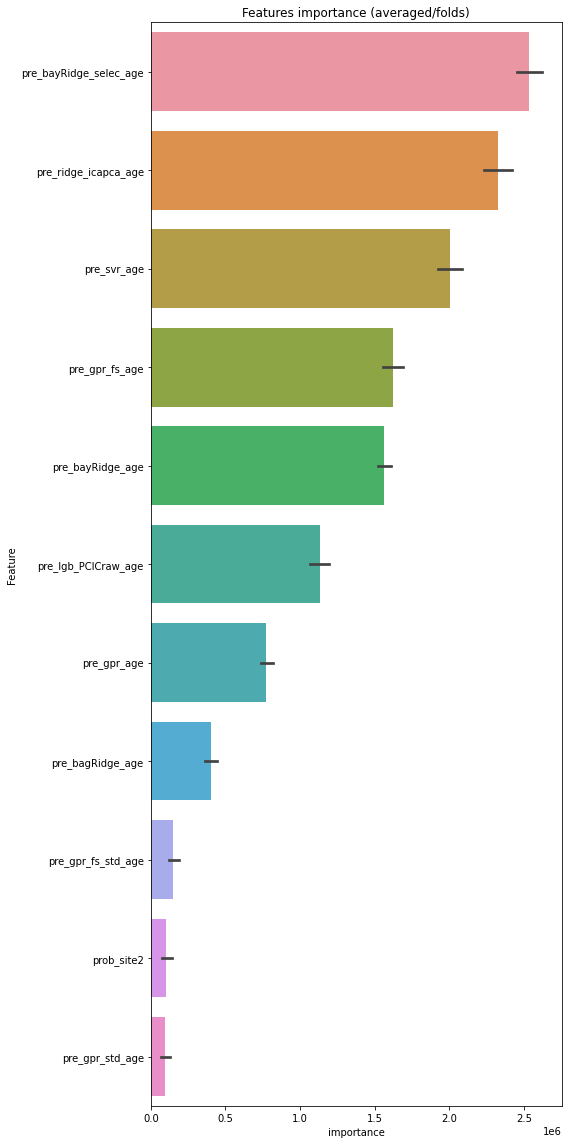

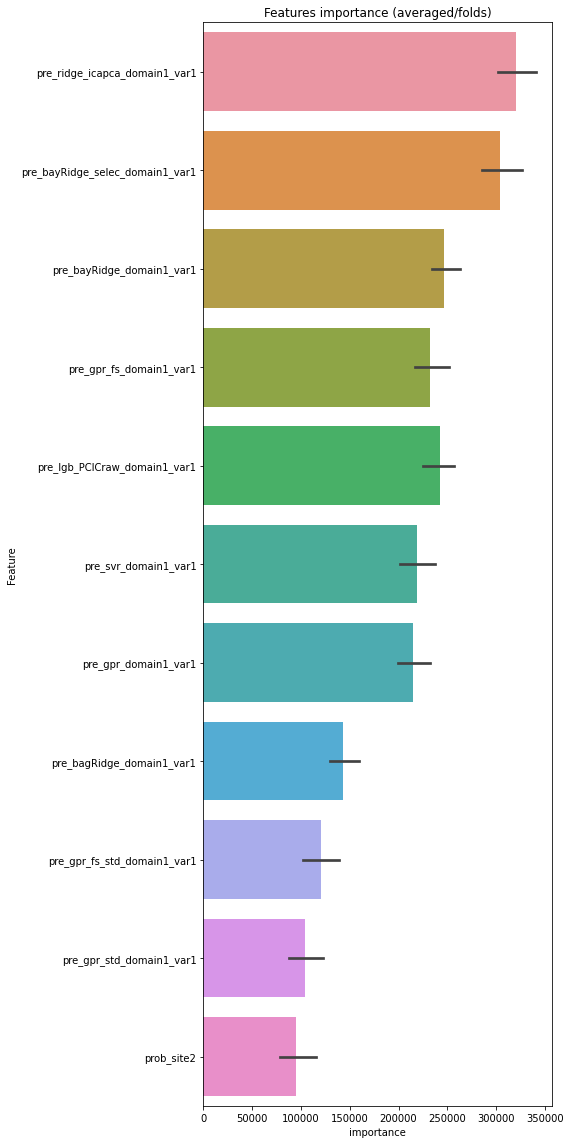

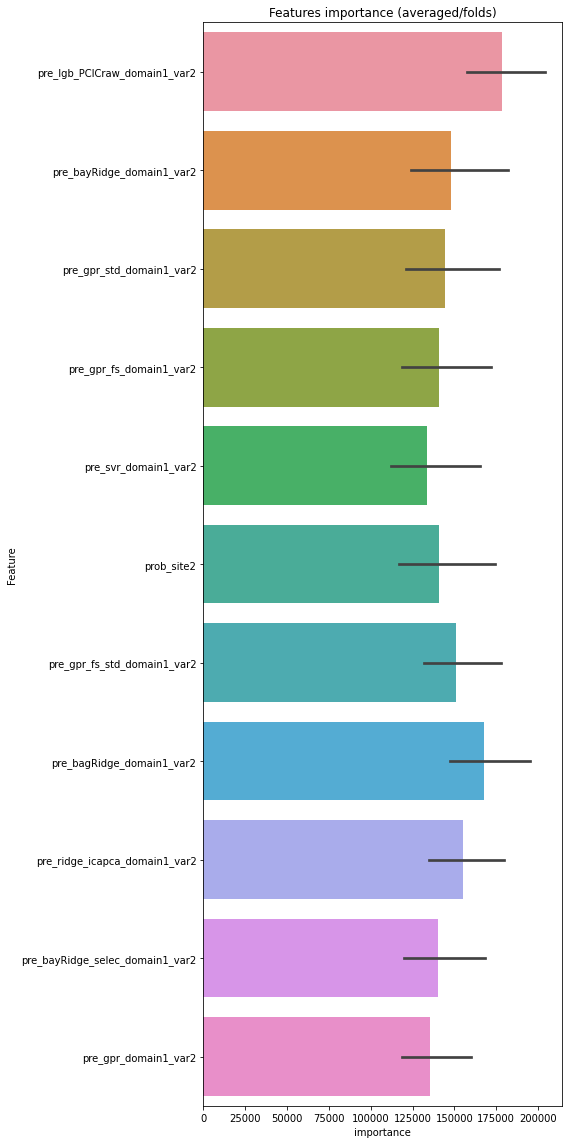

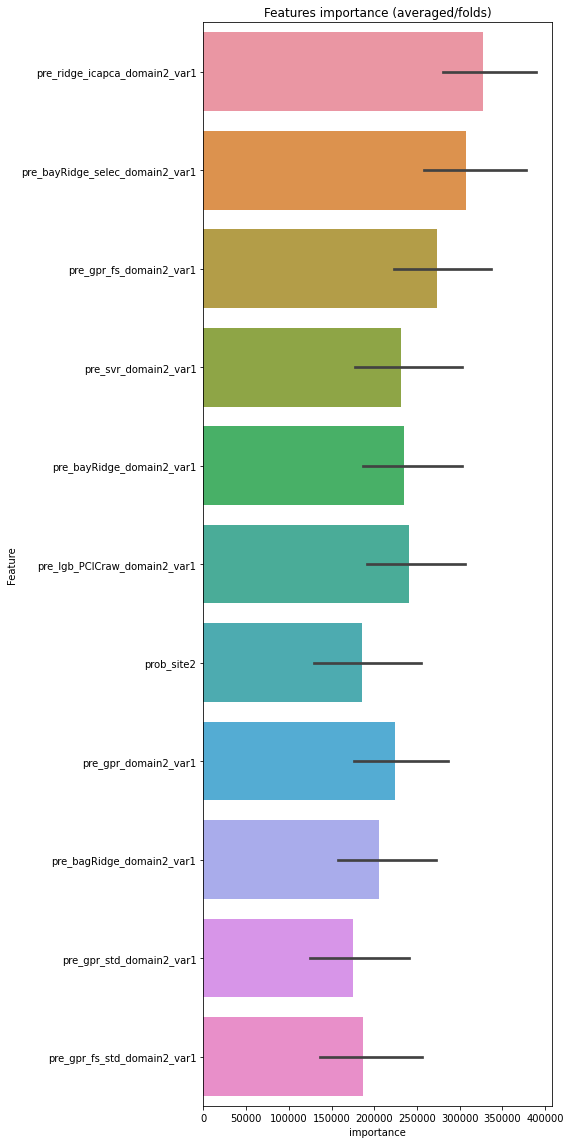

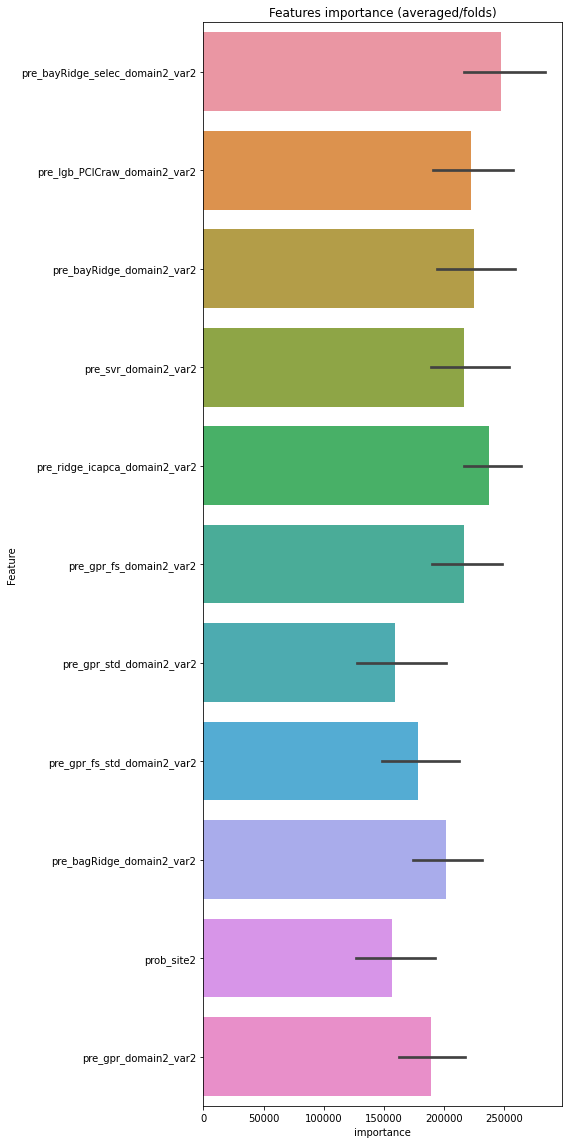

In [245]:
layer2_pred_train_targets_lgb = {}
layer2_pred_test_targets_lgb = {}

layer2_pred_train_targets_lgb_dfs = {}
layer2_pred_test_targets_lgb_dfs = {}

overal_score = 0

print("N_FOLD:{}".format(N_FOLD))

for target, w in [("age", 0.3),
                  ("domain1_var1", 0.175),
                  ("domain1_var2", 0.175),
                  ("domain2_var1", 0.175),
                  ("domain2_var2", 0.175)]:
    target_columns = list(pred_train_dfs.loc[
        :, pred_train_dfs.columns.str.contains('_'+target)
    ].columns)
    target_columns.append('prob_site2')
    train_df2 = pred_train_dfs[pred_train_dfs[target].notnull()]
    use_idx = train_df2.index
    train_x_2 = train_df2[target_columns]
    #ss.fit(train_x_2)
    #train_x_2 = ss.fit_transform(train_x_2)
    #train_x_2 = pd.DataFrame(train_x_2)
    
    train_y = train_df2[target]
    
    test_df2 = pred_test_dfs
    test_x_2 = test_df2[target_columns]
    #test_x_2 = ss.fit_transform(test_x_2)
    #test_x_2 = pd.DataFrame(test_x_2)
    
    print("-----{}-----".format(target))
    pred_train, preds_test, score_cv, fi = predict_cv_lgb(train_x=train_x_2,
                                                          train_y=train_y,
                                                          test_x=test_x_2,
                                                          target_name=target,
                                                          param=lgb_param)
    show_feature_importance(fi, target)
    overal_score += w*score_cv
    layer2_pred_train_targets_lgb[target] = pred_train
    layer2_pred_test_targets_lgb[target] = preds_test
    
    layer2_pred_train_targets_lgb_dfs[target] = pd.Series(pred_train, name="layer2_pred_lgb_{}".format(target), index=use_idx)
    layer2_pred_train_targets_lgb_dfs[target] = pd.merge(train['Id'],
                                                 layer2_pred_train_targets_lgb_dfs[target],
                                                 left_index=True,
                                                 right_index=True)
    layer2_pred_test_targets_lgb_dfs[target] = pd.Series(preds_test, name="layer2_pred_lgb_2{}".format(target))
    layer2_pred_test_targets_lgb_dfs[target] = pd.concat([test['Id'], layer2_pred_test_targets_lgb_dfs[target]], axis=1)

    
    
print('--------------------------------------------')
print("Overal score:", np.round(overal_score, 8))

In [ ]:
/media/hiroki/working/kaggle/trends-neuroimaging/models/submit/final_submit.csv

In [ ]:
N_FOLD:15
-----age-----
age_score:0.14125185
-----domain1_var1-----
domain1_var1_score:0.1507176
-----domain1_var2-----
domain1_var2_score:0.15093811
-----domain2_var1-----
domain2_var1_score:0.18108484
-----domain2_var2-----
domain2_var2_score:0.17594231
--------------------------------------------
Overal score: 0.15764505

In [249]:
for i, pred_df in enumerate(layer2_pred_train_targets_lgb_dfs.values()):
    display(pred_df.describe())

,layer2_pred_lgb_age
count,5877.000000
mean,49.936461
std,10.113598
min,29.746927
25%,41.987828


,layer2_pred_lgb_domain1_var1
count,5439.000000
mean,51.179628
std,3.319187
min,43.476676
25%,48.672980


,layer2_pred_lgb_domain1_var2
count,5439.000000
mean,58.872801
std,1.159300
min,54.297509
25%,58.109192


,layer2_pred_lgb_domain2_var1
count,5838.000000
mean,47.037333
std,2.639134
min,39.819806
25%,44.994052


,layer2_pred_lgb_domain2_var2
count,5838.000000
mean,51.538286
std,2.166438
min,45.099892
25%,49.768118


In [248]:
for i, pred_df in enumerate(layer2_pred_train_targets_bayes_ridge_dfs.values()):
    display(pred_df.describe())

,layer2_pred_bayes_ridge_age
count,5877.000000
mean,50.039464
std,10.146677
min,20.483826
25%,42.580664


,layer2_pred_bayes_ridge_domain1_var1
count,5439.000000
mean,51.464372
std,3.222429
min,40.207178
25%,49.252975


,layer2_pred_bayes_ridge_domain1_var2
count,5439.000000
mean,59.240630
std,0.832274
min,55.913625
25%,58.703461


,layer2_pred_bayes_ridge_domain2_var1
count,5838.000000
mean,47.346664
std,2.426580
min,39.556969
25%,45.670735


,layer2_pred_bayes_ridge_domain2_var2
count,5838.000000
mean,51.900767
std,2.037426
min,43.444676
25%,50.521974


In [246]:
for i, pred_df in enumerate(layer2_pred_test_targets_lgb_dfs.values()):
    if i == 0:
        layer2_lgb_test = pd.concat([test['Id'], pred_df.drop("Id", axis=1)], axis=1)
    else:
        layer2_lgb_test = pd.concat([layer2_lgb_test, pred_df.drop("Id", axis=1)], axis=1)

In [114]:
layer2_lgb_test = pd.DataFrame(layer2_lgb_test.values, columns=["Id"]+TARGET_COLS)

In [256]:
for i, pred_df in enumerate(layer2_pred_train_targets_lgb_dfs.values()):
    if i == 0:
        layer2_lgb_train = pd.concat([train['Id'], pred_df.drop("Id", axis=1)], axis=1)
    else:
        layer2_lgb_train = pd.concat([layer2_lgb_train, pred_df.drop("Id", axis=1)], axis=1)

In [258]:
sub_lgb_df = pd.melt(layer2_lgb_train[layer2_lgb_train.columns], id_vars=["Id"], value_name="Predicted")
sub_lgb_df["Id"] = sub_lgb_df["Id"].astype("str") + "_" +  sub_lgb_df["variable"].astype("str")

sub_lgb_df = sub_lgb_df.drop("variable", axis=1).sort_values("Id")
assert sub_lgb_df.shape[0] == test_df.shape[0]*5
sub_lgb_df.head(10)

,Id,Predicted
0,10001_layer2_pred_lgb_age,62.722584
5877,10001_layer2_pred_lgb_domain1_var1,53.802977
11754,10001_layer2_pred_lgb_domain1_var2,59.248163
17631,10001_layer2_pred_lgb_domain2_var1,49.619565
23508,10001_layer2_pred_lgb_domain2_var2,50.100960
1,10002_layer2_pred_lgb_age,58.247686
5878,10002_layer2_pred_lgb_domain1_var1,53.281455
11755,10002_layer2_pred_lgb_domain1_var2,57.734052
17632,10002_layer2_pred_lgb_domain2_var1,46.112432
23509,10002_layer2_pred_lgb_domain2_var2,51.225309


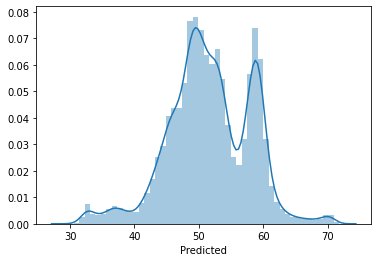

In [261]:
sns.distplot(sub_lgb_df['Predicted'])

In [116]:
sub_lgb_df['Predicted'] = sub_lgb_df['Predicted'].astype('float64')

In [118]:
sub_lgb_df.to_csv('/media/hiroki/working/kaggle/trends-neuroimaging/models/submit/sub_lgb.csv', index=False)

In [ ]:
N_FOLD:15
-----age-----
age_score:0.14186325
age_mae:7.096791648313459
age_rmse:8.977848562645116
-----domain1_var1-----
domain1_var1_score:0.1509722
domain1_var1_mae:7.772129797463302
domain1_var1_rmse:9.658406892292279
-----domain1_var2-----
domain1_var2_score:0.15171128
domain1_var2_mae:8.986419837686078
domain1_var2_rmse:11.369964706068032
-----domain2_var1-----
domain2_var1_score:0.18091074
domain2_var1_mae:8.559282670804375
domain2_var1_rmse:10.83439571101249
-----domain2_var2-----
domain2_var2_score:0.17689568
domain2_var2_mae:9.178516782204825
domain2_var2_rmse:11.676486588203163
--------------------------------------------
Overal score: 0.15814471

In [ ]:
N_FOLD:15
-----age-----
age_score:0.14228535
age_mae:7.118012486615155
age_rmse:9.003778356240447
-----domain1_var1-----
domain1_var1_score:0.15101503
domain1_var1_mae:7.77434392423173
domain1_var1_rmse:9.66478027076619
-----domain1_var2-----
domain1_var2_score:0.15158504
domain1_var2_mae:8.978948528548566
domain1_var2_rmse:11.361392986348575
-----domain2_var1-----
domain2_var1_score:0.18097177
domain2_var1_mae:8.56214645127534
domain2_var1_rmse:10.838142252500711
-----domain2_var2-----
domain2_var2_score:0.17675288
domain2_var2_mae:9.171150142902837
domain2_var2_rmse:11.674198251553069
--------------------------------------------
Overal score: 0.15824243

In [ ]:
N_FOLD:15
-----age-----
age_score:0.14276881
age_mae:7.142316300932006
age_rmse:9.028329896880477
-----domain1_var1-----
domain1_var1_score:0.1513409
domain1_var1_mae:7.7910279241380636
domain1_var1_rmse:9.683627849645118
-----domain1_var2-----
domain1_var2_score:0.15168961
domain1_var2_mae:8.985089126132364
domain1_var2_rmse:11.37556589320008
-----domain2_var1-----
domain2_var1_score:0.18142767
domain2_var1_mae:8.583642787613751
domain2_var1_rmse:10.868442716726836
-----domain2_var2-----
domain2_var2_score:0.17718602
domain2_var2_mae:9.193739371801911
domain2_var2_rmse:11.68763580724886
--------------------------------------------
Overal score: 0.15861838

In [78]:
for i, pred_df in enumerate(layer2_pred_train_targets_lgb_dfs.values()):
    pred_2nd_train_df = pd.concat([pred_2nd_train_df, pred_df.drop("Id", axis=1)], axis=1)

for i, pred_df in enumerate(layer2_pred_test_targets_lgb_dfs.values()):
    pred_2nd_test_df = pd.concat([pred_2nd_test_df, pred_df.drop("Id", axis=1)], axis=1)

In [79]:
pred_2nd_train_df

,Id,layer2_pred_bayes_ridge_age,layer2_pred_bayes_ridge_domain1_var1,layer2_pred_bayes_ridge_domain1_var2,layer2_pred_bayes_ridge_domain2_var1,layer2_pred_bayes_ridge_domain2_var2,layer2_pred_lgb_age,layer2_pred_lgb_domain1_var1,layer2_pred_lgb_domain1_var2,layer2_pred_lgb_domain2_var1,layer2_pred_lgb_domain2_var2
0,10001,62.364157,54.773343,58.404867,48.721625,51.429389,62.722584,53.802977,59.248163,49.619565,50.100960
1,10002,57.445873,53.649613,58.943419,46.331888,51.251181,58.247686,53.281455,57.734052,46.112432,51.225309
2,10004,52.247185,52.209445,59.566013,46.903315,49.736552,52.710679,52.260889,62.105660,46.558342,49.877364
3,10005,61.088816,NaN,NaN,48.522602,52.954824,60.864512,NaN,NaN,49.113484,53.226692
4,10007,44.723651,49.856701,57.950844,45.656952,51.648102,42.749521,47.928070,59.745892,44.178151,52.123303
...,...,...,...,...,...,...,...,...,...,...,...
5872,21746,31.477705,49.502616,59.464902,45.665389,49.882668,31.853517,48.744237,60.359979,45.047239,50.832130
5873,21747,49.677645,48.156405,58.864441,46.582965,52.867283,51.759231,47.590147,59.075280,46.952971,53.018510
5874,21750,41.971237,49.668322,60.433608,46.040888,52.401355,41.681947,50.458610,59.713140,44.844205,51.194585
5875,21752,55.460993,55.433061,58.670784,46.762451,52.084494,55.810852,57.430234,57.737810,47.789348,50.795362


In [112]:
pred_2nd_test_df

,Id,layer2_pred_bayes_ridge_age,layer2_pred_bayes_ridge_domain1_var1,layer2_pred_bayes_ridge_domain1_var2,layer2_pred_bayes_ridge_domain2_var1,layer2_pred_bayes_ridge_domain2_var2,layer2_pred_lgb_2age,layer2_pred_lgb_2domain1_var1,layer2_pred_lgb_2domain1_var2,layer2_pred_lgb_2domain2_var1,layer2_pred_lgb_2domain2_var2,layer2_pre_gpr_age,layer2_pre_gpr_domain1_var1,layer2_pre_gpr_domain1_var2,layer2_pre_gpr_domain2_var1,layer2_pre_gpr_domain2_var2
0,10003,56.900539,49.381608,59.097112,50.823169,57.200183,56.981530,48.967326,57.793984,49.968395,56.115212,56.005671,49.457421,59.053929,49.994196,56.279964
1,10006,64.084607,54.228698,58.930031,48.992081,51.868335,62.405760,53.427710,58.078863,48.300903,50.405860,63.318706,54.264472,58.990313,48.873406,51.936923
2,10010,38.452675,49.491813,59.532482,44.816924,53.239648,35.977708,47.976524,60.350372,43.282824,52.932245,37.328488,49.521726,59.564610,44.843384,53.290617
3,10011,50.902670,52.341599,60.176984,49.165201,50.690494,50.196096,52.646509,59.852412,47.830281,49.059650,49.934895,52.381127,60.090791,48.696051,50.615421
4,10012,53.637276,55.333161,56.710636,47.789441,58.383262,54.538190,55.611930,56.456149,46.432826,56.582017,52.670280,55.419766,56.869550,46.998587,57.411470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5872,21745,40.748946,51.014200,58.467298,45.667546,53.294992,38.960461,51.447088,57.730895,45.530829,54.058091,39.646094,50.974570,58.606008,45.820037,53.611023
5873,21748,56.159593,56.319508,60.030826,47.572899,52.479094,55.656883,56.200236,59.127691,49.027503,52.053934,55.265008,56.388298,59.978923,47.536799,52.561301
5874,21749,42.742225,46.615431,59.340376,45.816568,51.688779,38.623409,46.085832,59.134338,45.496999,50.622074,41.648924,46.668593,59.315526,45.422577,51.458327
5875,21751,40.963176,49.889302,58.578899,45.311392,55.947781,39.131870,50.284663,57.252460,44.219394,55.187489,39.848079,49.951062,58.629527,45.072080,55.626582


In [ ]:
sub_df = pd.melt(test_df[], id_vars=["Id"], value_name="Predicted")
sub_df["Id"] = sub_df["Id"].astype("str") + "_" +  sub_df["variable"].astype("str")

sub_df = sub_df.drop("variable", axis=1).sort_values("Id")
assert sub_df.shape[0] == test_df.shape[0]*5
sub_df.head(10)

# RF

In [ ]:
n_estimators = 1500, max_depth=6
N_FOLD:15
age_score:0.14301036298274994
-----domain1_var1-----
domain1_var1_score:0.15119963884353638
-----domain1_var2-----
domain1_var2_score:0.15119509398937225
-----domain2_var1-----
domain2_var1_score:0.1811087727546692
-----domain2_var2-----
domain2_var2_score:0.1766304224729538
--------------------------------------------
Overal score: 0.15842655

# GPR

In [80]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel, Matern, DotProduct
#from sklearn.model_selection import train_test_split, GridSearchCV

In [84]:
# 学習データに対する「目的変数を知らない」予測値と、テストデータに対する予測値を返す関数
def gpr_predict_cv(train_x, train_y, test_x, model, target_name):
    preds = []
    preds_std = []
    
    preds_test = []
    preds_test_std = []
    
    va_idxes = []
    
    score = []
    mae = []
    rmse = []

    # shuffleしなくても良い
    kf = KFold(n_splits=15, shuffle=True, random_state=SEED)

    # クロスバリデーションで学習・予測を行い、予測値とインデックスを保存する
    for i, (tr_idx, va_idx) in enumerate(kf.split(train_x)):
        print("FOLD:{}".format(i+1))
        tr_x, va_x = train_x.iloc[tr_idx].values, train_x.iloc[va_idx].values
        tr_y, va_y = train_y.iloc[tr_idx].values, train_y.iloc[va_idx].values
        
        # autoscaling
        autoscaled_train_x = (tr_x - tr_x.mean(axis=0)) / tr_x.std(axis=0, ddof=1)
        autoscaled_train_y = (tr_y - tr_y.mean()) / tr_y.std(ddof=1)
        autoscaled_val_x = (va_x - tr_x.mean(axis=0)) / tr_x.std(axis=0, ddof=1)
        autoscaled_test_x = (test_x - tr_x.mean(axis=0)) / tr_x.std(axis=0, ddof=1)
        
        model.fit(autoscaled_train_x, autoscaled_train_y)
        # pred_val
        pred, pred_std = model.predict(autoscaled_val_x, return_std=True)
        pred = pred * tr_y.std(ddof=1) + tr_y.mean()
        preds.append(pred)
        # pred_val_std
        pred_std = pred_std * tr_y.std(ddof=1)
        preds_std.append(pred_std)
        # append valid idx
        va_idxes.append(va_idx)
        # pred_test
        pred_test, pred_test_std = model.predict(autoscaled_test_x, return_std=True)
        pred_test = pred_test * tr_y.std(ddof=1) + tr_y.mean()
        preds_test.append(pred_test)
        # pred_test_std
        pred_test_std = pred_test_std * tr_y.std(ddof=1)
        preds_test_std.append(pred_test_std)
        
        # calc score
        score.append(metric(va_y, pred))
        mae.append(mean_absolute_error(va_y, pred))
        rmse.append(np.sqrt(mean_squared_error(va_y, pred)))
        
    score_cv = np.array(score).mean()
    mae_cv = np.array(mae).mean()
    rmse_cv = np.array(rmse).mean()
    print("{0}_score:{1}".format(target_name, np.round(score_cv, 8)))
    print("{0}_mae:{1}".format(target_name, np.array(mae_cv).mean()))
    print("{0}_rmse:{1}".format(target_name, np.array(rmse_cv).mean()))
    # バリデーションデータに対する予測値を連結し、その後元の順序に並べ直す
    va_idxes = np.concatenate(va_idxes)
    preds = np.concatenate(preds, axis=0)
    preds_std = np.concatenate(preds_std, axis=0)
    
    order = np.argsort(va_idxes)
    
    pred_train = preds[order]
    pred_std_train = preds_std[order]

    # テストデータに対する予測値の平均をとる
    pred_test = np.mean(preds_test, axis=0)
    pred_test_std = np.mean(preds_test_std, axis=0)

    return pred_train, pred_std_train, pred_test, pred_test_std, score_cv

In [85]:
kernels = [ConstantKernel() * DotProduct() + WhiteKernel(),
           ConstantKernel() * RBF() + WhiteKernel(),
           ConstantKernel() * RBF() + WhiteKernel() + ConstantKernel() * DotProduct(),
           ConstantKernel() * Matern(nu=1.5) + WhiteKernel(),
           ConstantKernel() * Matern(nu=1.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
           ConstantKernel() * Matern(nu=0.5) + WhiteKernel(),
           ConstantKernel() * Matern(nu=0.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
           ConstantKernel() * Matern(nu=2.5) + WhiteKernel(),
           ConstantKernel() * Matern(nu=2.5) + WhiteKernel() + ConstantKernel() * DotProduct()]

In [86]:
#pred_train_targets_gpr = {}
#pred_test_targets_gpr = {}

layer2_pred_train_targets_gpr_dfs = {}
layer2_pred_train_targets_std_gpr_dfs = {}

layer2_pred_test_targets_gpr_dfs = {}
layer2_pred_test_targets_std_gpr_dfs = {}

overal_score = 0

print("N_FOLD:{}".format(5))

for target, w in [("age", 0.3),
                  ("domain1_var1", 0.175),
                  ("domain1_var2", 0.175),
                  ("domain2_var1", 0.175),
                  ("domain2_var2", 0.175)]:
    
    target_columns = list(pred_train_dfs.loc[
        :, pred_train_dfs.columns.str.contains('_'+target)
    ].columns)
    
    
    train_df2 = pred_train_dfs[pred_train_dfs[target].notnull()]
    use_idx = train_df2.index
    test_df = test
        
    use_idx = train_df2.index
    train_x_2 = train_df2[target_columns]
    
    train_y = train_df2[target]
    
    test_df2 = pred_test_dfs
    test_x_2 = test_df2[target_columns]
    
    model = GaussianProcessRegressor(kernels[0], alpha=0, random_state=2020)
    
    print("-----{}-----".format(target))
    pred_train, pred_std_train, pred_test, pred_std_test, score_cv = gpr_predict_cv(train_x=train_x_2,
                                                                                    train_y=train_y,
                                                                                    test_x=test_x_2,
                                                                                    model=model,
                                                                                    target_name=target)
    overal_score += w*score_cv
    # make pred_train_df
    layer2_pred_train_targets_gpr_dfs[target] = pd.Series(pred_train, name="layer2_pre_gpr_{}".format(target), index=use_idx)
    layer2_pred_train_targets_gpr_dfs[target] = pd.merge(train['Id'],
                                                 layer2_pred_train_targets_gpr_dfs[target],
                                                 left_index=True,
                                                 right_index=True)
    # make pred_train_std_df
    layer2_pred_train_targets_std_gpr_dfs[target] = pd.Series(pred_std_train, name="layer2_pre_gpr_std_{}".format(target), index=use_idx)
    layer2_pred_train_targets_std_gpr_dfs[target] = pd.merge(train['Id'],
                                                      layer2_pred_train_targets_std_gpr_dfs[target],
                                                      left_index=True,
                                                      right_index=True)
    # make pred_test_df
    layer2_pred_test_targets_gpr_dfs[target] = pd.Series(pred_test, name="layer2_pre_gpr_{}".format(target))
    layer2_pred_test_targets_gpr_dfs[target] = pd.concat([test['Id'], layer2_pred_test_targets_gpr_dfs[target]], axis=1)
    # make pred_test_std_df
    layer2_pred_test_targets_std_gpr_dfs[target] = pd.Series(pred_std_test, name="layer2_pre_gpr_std_{}".format(target))
    layer2_pred_test_targets_std_gpr_dfs[target] = pd.concat([test['Id'], layer2_pred_test_targets_std_gpr_dfs[target]], axis=1)
    
print('--------------------------------------------')
print("Overal score:", np.round(overal_score, 8))

N_FOLD:5
-----age-----
FOLD:1
FOLD:2
FOLD:3
FOLD:4
FOLD:5
FOLD:6
FOLD:7
FOLD:8
FOLD:9
FOLD:10
FOLD:11
FOLD:12
FOLD:13
FOLD:14
FOLD:15
age_score:0.14125179
age_mae:7.066424301854416
age_rmse:8.959344304479403
-----domain1_var1-----
FOLD:1
FOLD:2
FOLD:3
FOLD:4
FOLD:5
FOLD:6
FOLD:7
FOLD:8
FOLD:9
FOLD:10
FOLD:11
FOLD:12
FOLD:13
FOLD:14
FOLD:15
domain1_var1_score:0.15071828
domain1_var1_mae:7.7589968235218345
domain1_var1_rmse:9.656226967968857
-----domain1_var2-----
FOLD:1
FOLD:2
FOLD:3
FOLD:4
FOLD:5
FOLD:6
FOLD:7
FOLD:8
FOLD:9
FOLD:10
FOLD:11
FOLD:12
FOLD:13
FOLD:14
FOLD:15
domain1_var2_score:0.15093769
domain1_var2_mae:8.940620544266247
domain1_var2_rmse:11.349777179268042
-----domain2_var1-----
FOLD:1
FOLD:2
FOLD:3
FOLD:4
FOLD:5
FOLD:6
FOLD:7
FOLD:8
FOLD:9
FOLD:10
FOLD:11
FOLD:12
FOLD:13
FOLD:14
FOLD:15
domain2_var1_score:0.18108619
domain2_var1_mae:8.567659363877008
domain2_var1_rmse:10.851024847056912
-----domain2_var2-----
FOLD:1
FOLD:2
FOLD:3
FOLD:4
FOLD:5
FOLD:6
FOLD:7
FOLD:8
FOLD:

In [87]:
for i, pred_df in enumerate(layer2_pred_train_targets_gpr_dfs.values()):
    pred_2nd_train_df = pd.concat([pred_2nd_train_df, pred_df.drop("Id", axis=1)], axis=1)

for i, pred_df in enumerate(layer2_pred_test_targets_gpr_dfs.values()):
    pred_2nd_test_df = pd.concat([pred_2nd_test_df, pred_df.drop("Id", axis=1)], axis=1)

In [98]:
for i, pred_df in enumerate(layer2_pred_test_targets_gpr_dfs.values()):
    if i == 0:
        layer2_gpr_test = pd.concat([test['Id'], pred_df.drop("Id", axis=1)], axis=1)
    else:
        layer2_gpr_test = pd.concat([layer2_gpr_test, pred_df.drop("Id", axis=1)], axis=1)

In [106]:
layer2_gpr_test = pd.DataFrame(layer2_gpr_test.values, columns=["Id"]+TARGET_COLS)

In [107]:
sub_gpr_df = pd.melt(layer2_gpr_test[["Id", "age", "domain1_var1", "domain1_var2", "domain2_var1", "domain2_var2"]], id_vars=["Id"], value_name="Predicted")
sub_gpr_df["Id"] = sub_gpr_df["Id"].astype("str") + "_" +  sub_gpr_df["variable"].astype("str")

sub_gpr_df = sub_gpr_df.drop("variable", axis=1).sort_values("Id")
assert sub_gpr_df.shape[0] == test_df.shape[0]*5
sub_gpr_df.head(10)

,Id,Predicted
0,10003_age,56.0057
5877,10003_domain1_var1,49.4574
11754,10003_domain1_var2,59.0539
17631,10003_domain2_var1,49.9942
23508,10003_domain2_var2,56.28
1,10006_age,63.3187
5878,10006_domain1_var1,54.2645
11755,10006_domain1_var2,58.9903
17632,10006_domain2_var1,48.8734
23509,10006_domain2_var2,51.9369


In [109]:
sub_gpr_df['Predicted'] = sub_gpr_df['Predicted'].astype('float64')

In [111]:
sub_gpr_df.to_csv('/media/hiroki/working/kaggle/trends-neuroimaging/models/submit/sub_gpr.csv', index=False)

In [ ]:
sub_gpr_df

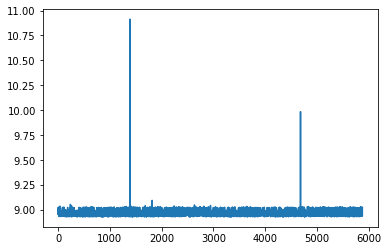

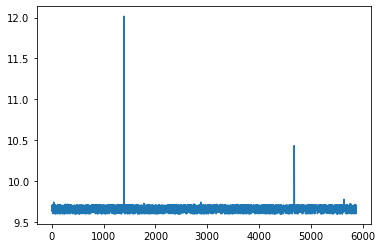

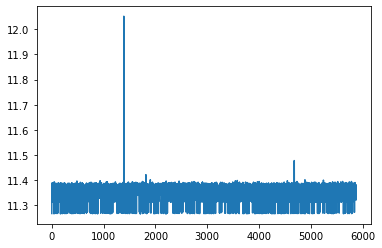

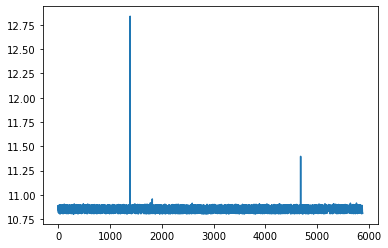

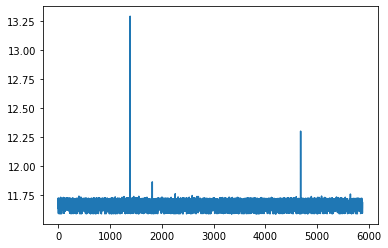

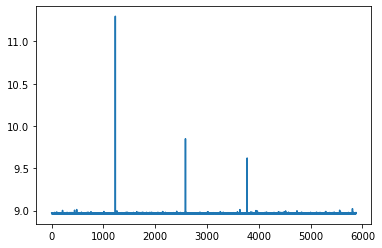

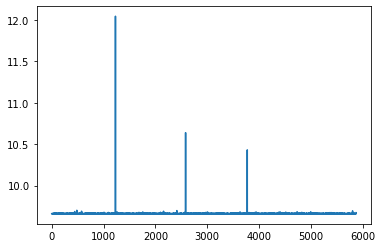

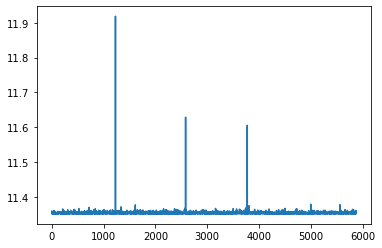

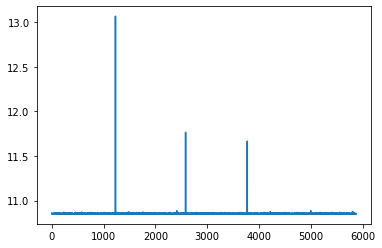

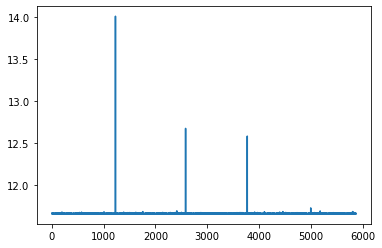

In [89]:
for i, std_df in enumerate(layer2_pred_train_targets_std_gpr_dfs.values()):
    plt.plot(std_df[std_df.columns[1]])
    plt.show()
for i, std_df in enumerate(layer2_pred_test_targets_std_gpr_dfs.values()):
    plt.plot(std_df[std_df.columns[1]])
    plt.show()

# weighted average

In [196]:
pred_2nd_train_df

,Id,layer2_pred_bayes_ridge_age,layer2_pred_bayes_ridge_domain1_var1,layer2_pred_bayes_ridge_domain1_var2,layer2_pred_bayes_ridge_domain2_var1,layer2_pred_bayes_ridge_domain2_var2
0,10001,62.364157,54.773343,58.404867,48.721625,51.429389
1,10002,57.445873,53.649613,58.943419,46.331888,51.251181
2,10004,52.247185,52.209445,59.566013,46.903315,49.736552
3,10005,61.088816,NaN,NaN,48.522602,52.954824
4,10007,44.723651,49.856701,57.950844,45.656952,51.648102
...,...,...,...,...,...,...
5872,21746,31.477705,49.502616,59.464902,45.665389,49.882668
5873,21747,49.677645,48.156405,58.864441,46.582965,52.867283
5874,21750,41.971237,49.668322,60.433608,46.040888,52.401355
5875,21752,55.460993,55.433061,58.670784,46.762451,52.084494


In [197]:
pred_2nd_test_df

,Id,layer2_pred_bayes_ridge_age,layer2_pred_bayes_ridge_domain1_var1,layer2_pred_bayes_ridge_domain1_var2,layer2_pred_bayes_ridge_domain2_var1,layer2_pred_bayes_ridge_domain2_var2
0,10003,56.900539,49.381608,59.097112,50.823169,57.200183
1,10006,64.084607,54.228698,58.930031,48.992081,51.868335
2,10010,38.452675,49.491813,59.532482,44.816924,53.239648
3,10011,50.902670,52.341599,60.176984,49.165201,50.690494
4,10012,53.637276,55.333161,56.710636,47.789441,58.383262
...,...,...,...,...,...,...
5872,21745,40.748946,51.014200,58.467298,45.667546,53.294992
5873,21748,56.159593,56.319508,60.030826,47.572899,52.479094
5874,21749,42.742225,46.615431,59.340376,45.816568,51.688779
5875,21751,40.963176,49.889302,58.578899,45.311392,55.947781


In [198]:
age_columns = list(pred_2nd_test_df.loc[
        :, pred_2nd_test_df.columns.str.contains('age')
    ].columns)
d1v1_columns = list(pred_2nd_test_df.loc[
        :, pred_2nd_test_df.columns.str.contains('domain1_var1')
    ].columns)
d1v2_columns = list(pred_2nd_test_df.loc[
        :, pred_2nd_test_df.columns.str.contains('domain1_var2')
    ].columns)
d2v1_columns = list(pred_2nd_test_df.loc[
        :, pred_2nd_test_df.columns.str.contains('domain2_var1')
    ].columns)
d2v2_columns = list(pred_2nd_test_df.loc[
        :, pred_2nd_test_df.columns.str.contains('domain2_var2')
    ].columns)

In [154]:
test_age = pred_2nd_test_df[age_columns].mean(axis=1)
test_d1v1 = pred_2nd_test_df[d1v1_columns].mean(axis=1)
test_d1v2 = pred_2nd_test_df[d1v2_columns].mean(axis=1)
test_d2v1 = pred_2nd_test_df[d2v1_columns].mean(axis=1)
test_d2v2 = pred_2nd_test_df[d2v2_columns].mean(axis=1)

In [155]:
#pred_2nd_train_df[d1v1_columns].mean(axis=1).describe()

In [156]:
#test_df

In [157]:
layer3rd_test = pd.concat([test_age,test_d1v1,test_d1v2,test_d2v1,test_d2v2],axis=1)

In [158]:
TARGET_COLS

['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']

In [159]:
layer3rd_test.rename({0:TARGET_COLS[0], 1:TARGET_COLS[1], 2:TARGET_COLS[2], 3:TARGET_COLS[3], 4:TARGET_COLS[4]}, axis=1, inplace=True)

In [160]:
layer3rd_test = pd.concat([test['Id'], layer3rd_test], axis=1)

# Submit

In [75]:
pred_2nd_test_df

,Id,layer2_pred_bayes_ridge_age,layer2_pred_bayes_ridge_domain1_var1,layer2_pred_bayes_ridge_domain1_var2,layer2_pred_bayes_ridge_domain2_var1,layer2_pred_bayes_ridge_domain2_var2
0,10003,56.900539,49.381608,59.097112,50.823169,57.200183
1,10006,64.084607,54.228698,58.930031,48.992081,51.868335
2,10010,38.452675,49.491813,59.532482,44.816924,53.239648
3,10011,50.902670,52.341599,60.176984,49.165201,50.690494
4,10012,53.637276,55.333161,56.710636,47.789441,58.383262
...,...,...,...,...,...,...
5872,21745,40.748946,51.014200,58.467298,45.667546,53.294992
5873,21748,56.159593,56.319508,60.030826,47.572899,52.479094
5874,21749,42.742225,46.615431,59.340376,45.816568,51.688779
5875,21751,40.963176,49.889302,58.578899,45.311392,55.947781


In [161]:
layer3rd_test

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10003,56.941035,49.174467,58.445548,50.395782,56.657697
1,10006,63.245183,53.828204,58.504447,48.646492,51.137098
2,10010,37.215192,48.734169,59.941427,44.049874,53.085947
3,10011,50.549383,52.494054,60.014698,48.497741,49.875072
4,10012,54.087733,55.472545,56.583392,47.111134,57.482639
...,...,...,...,...,...,...
5872,21745,39.854703,51.230644,58.099097,45.599187,53.676542
5873,21748,55.908238,56.259872,59.579258,48.300201,52.266514
5874,21749,40.682817,46.350632,59.237357,45.656783,51.155427
5875,21751,40.047523,50.086982,57.915680,44.765393,55.567635


In [199]:
test_df = pd.DataFrame(pred_2nd_test_df.values, columns=["Id"]+TARGET_COLS)
#test_df = #layer3rd_test

In [200]:
test_df

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10003,56.9005,49.3816,59.0971,50.8232,57.2002
1,10006,64.0846,54.2287,58.93,48.9921,51.8683
2,10010,38.4527,49.4918,59.5325,44.8169,53.2396
3,10011,50.9027,52.3416,60.177,49.1652,50.6905
4,10012,53.6373,55.3332,56.7106,47.7894,58.3833
...,...,...,...,...,...,...
5872,21745,40.7489,51.0142,58.4673,45.6675,53.295
5873,21748,56.1596,56.3195,60.0308,47.5729,52.4791
5874,21749,42.7422,46.6154,59.3404,45.8166,51.6888
5875,21751,40.9632,49.8893,58.5789,45.3114,55.9478


In [201]:
pred_2nd_test_df.describe()

,layer2_pred_bayes_ridge_age,layer2_pred_bayes_ridge_domain1_var1,layer2_pred_bayes_ridge_domain1_var2,layer2_pred_bayes_ridge_domain2_var1,layer2_pred_bayes_ridge_domain2_var2
count,5877.000000,5877.000000,5877.000000,5877.000000,5877.000000
mean,50.034428,51.474004,59.243898,47.326565,51.905332
std,10.174709,3.259921,0.869477,2.478039,2.157482
min,19.553220,40.097730,55.855517,39.421566,39.796389
25%,42.521464,49.204172,58.657245,45.557106,50.440586
50%,49.669117,51.502991,59.267823,47.275513,51.854327
75%,57.268316,53.718308,59.836527,49.012809,53.314539
max,83.285504,62.442406,63.291239,60.589173,60.527036


In [179]:
layer3rd_test.describe()

,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
count,5877.000000,5877.000000,5877.000000,5877.000000,5877.000000
mean,49.270807,51.446698,59.191528,47.176442,51.882203
std,10.116674,3.273079,0.890847,2.490703,2.055441
min,26.188032,43.123518,55.968233,40.825898,46.713918
25%,41.346616,48.984474,58.648492,45.185195,50.278315
50%,48.828175,51.622790,59.215793,46.961854,51.789174
75%,56.882041,53.541317,59.791651,49.283137,53.423941
max,75.849633,61.271772,62.155287,54.280331,57.592022


In [147]:
#layer3nd_test.to_csv('/media/hiroki/working/kaggle/trends-neuroimaging/models/submit/stacking_pre_test_layer3_ver2.csv')

In [79]:
sub_df = pd.melt(test_df[["Id", "age", "domain1_var1", "domain1_var2", "domain2_var1", "domain2_var2"]], id_vars=["Id"], value_name="Predicted")
sub_df["Id"] = sub_df["Id"].astype("str") + "_" +  sub_df["variable"].astype("str")

sub_df = sub_df.drop("variable", axis=1).sort_values("Id")
assert sub_df.shape[0] == test_df.shape[0]*5
sub_df.head(10)

,Id,Predicted
0,10003_age,56.9005
5877,10003_domain1_var1,49.3816
11754,10003_domain1_var2,59.0971
17631,10003_domain2_var1,50.8232
23508,10003_domain2_var2,57.2002
1,10006_age,64.0846
5878,10006_domain1_var1,54.2287
11755,10006_domain1_var2,58.93
17632,10006_domain2_var1,48.9921
23509,10006_domain2_var2,51.8683


In [80]:
sub_df.to_csv('/media/hiroki/working/kaggle/trends-neuroimaging/models/submit/stacking_pre_test_bayridge.csv', index=False)

In [83]:
stack_kernel = pd.read_csv("/media/hiroki/working/kaggle/trends-neuroimaging/models/submit/kernel_submit_data/submission.csv", dtype={'Id':str})

In [85]:
brending = sub_df.merge(stack_kernel, on=ID, how='left')
#train = train.merge(fnc, on=ID, how='left')

In [129]:
brending

NameError: name 'brending' is not defined

In [100]:
brending['Predicted_x'] = brending['Predicted_x'].astype('float64')

In [102]:
final_sub = pd.DataFrame(data={
    'id':sample_submission['Id'],
    'Predicted': 0.7*brending['Predicted_x'] + 0.3*brending['Predicted_y']
})

In [104]:
final_sub.to_csv('/media/hiroki/working/kaggle/trends-neuroimaging/models/submit/kernel_brend.csv', index=False)

# average

In [234]:
gpr_pre = pd.read_csv('/media/hiroki/working/kaggle/trends-neuroimaging/models/submit/sub_gpr.csv')
bayes_ridge_pre = pd.read_csv('/media/hiroki/working/kaggle/trends-neuroimaging/models/submit/stacking_pre_test_bayridge.csv')
lgb_pre = pd.read_csv('/media/hiroki/working/kaggle/trends-neuroimaging/models/submit/sub_lgb.csv')
stack_kernel = pd.read_csv("/media/hiroki/working/kaggle/trends-neuroimaging/models/submit/kernel_submit_data/fix_stack_kernel.csv", dtype={'Id':str})

In [219]:
fix_stack_kernel = bayes_ridge_pre.merge(stack_kernel, on=ID, how='left')

In [221]:
fix_stack_kernel.drop('Predicted_x', axis=1, inplace=True)

In [226]:
fix_stack_kernel.rename({'Predicted_y':'Predicted'}, axis=1, inplace=True)

In [231]:
fix_stack_kernel.to_csv("/media/hiroki/working/kaggle/trends-neuroimaging/models/submit/kernel_submit_data/fix_stack_kernel.csv", index=False)

In [233]:
stack_kernel

,Id,Predicted
0,10003_age,57.308382
1,10003_domain1_var1,49.814875
2,10003_domain1_var2,59.841746
3,10003_domain2_var1,50.463084
4,10003_domain2_var2,55.489793
...,...,...
29380,21753_age,42.990471
29381,21753_domain1_var1,43.642712
29382,21753_domain1_var2,59.517852
29383,21753_domain2_var1,46.056438


In [266]:
final_sub = pd.DataFrame(data={
    'id':sample_submission['Id'],
    'Predicted': 0.5*bayes_ridge_pre['Predicted'] + 0.2*gpr_pre['Predicted'] + 0.3*stack_kernel['Predicted']
})

In [267]:
final_sub.to_csv("/media/hiroki/working/kaggle/trends-neuroimaging/models/submit/final_submit.csv", index=False)

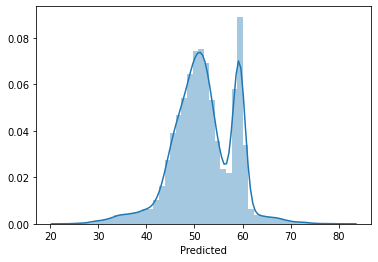

In [268]:
sns.distplot(final_sub['Predicted'])

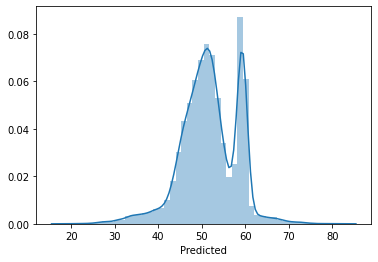

In [239]:
sns.distplot(gpr_pre['Predicted'])

In [127]:
bayes_ridge_pre.describe()

,Predicted
count,29385.000000
mean,51.996846
std,6.389880
min,19.553220
25%,48.082541
50%,51.626870
75%,57.521939
max,83.285504


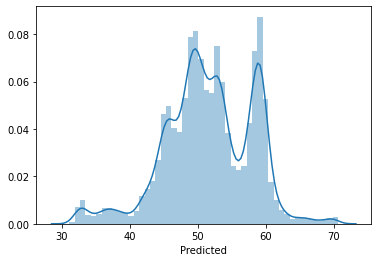

In [240]:
sns.distplot(lgb_pre['Predicted'])

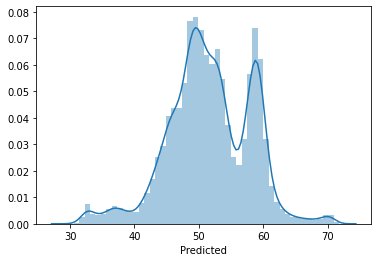

In [262]:
sns.distplot(sub_lgb_df['Predicted'])